# Проект телекоммуникации

# Описание проекта:
Для борьбы с оттоком клиентов оператор связи разрабатывает модель, которая будет прогнозировать, разорвёт ли абонент договор. Для этого используются данные о клиентах, их персональной информации, тарифах и услугах.

# Цель проекта:
Разработать модель, предсказывающую отток клиентов, с использованием данных о договорах, персональных данных, интернет-услугах и услугах телефонии.<br> Модель должна оптимизировать бизнес-метрику, учитывая потенциальные убытки от ложных предложений и упущенных клиентов.

**В качестве основной метрики примем `Auc-Roc`, в качестве дополнительной - `Accuracy`. <br>
Также определим основные признаки, вляющие на разрыв клиентом контракта для формирования рекомендаций заказчику.**

# Описание услуг

**Основные услуги:**
  + Стационарная телефонная связь
      - Возможность подключения мультилинии
  + Интернет. Два варианта подключения:
      - Телефонная линия - `DSL`
      - Оптоволоконный кабель - `Fiber optic`

**Дополнительные услуги:**
  + Интернет-безопасность:
  + Антивирус - `DeviceProtection`
  + Блокировка небезопасных сайтов - `OnlineSecurity`
  + Выделенная линия тех. поддержки - `TechSupport`
  + Облачное хранилище файлов для резервного копирования - `OnlineBackup`
  + Стриминговое телевидение - `StreamingTV`
  + Каталог фильмов - `StreamingMovies`

# План проекта

+ **Загрузка данных**
  
+ **Исследовательский анализ данных и предобработка**
    - Корректировка названий и типов данных столбцов
    - Создание целевого и дополнительных признаков
    - Обработка пропущенных значений и аномалий.
    - Визуализация и изучение распределения признаков с учетом статуса клиентов.
+ **Объединение данных**
    
    - Объединение данных из разных источников для создания общего датафрейма.
+ **Исследовательский анализ данных объединенного датафрейма**
  
    - Визуализация взаимосвязи признаков из разных датафреймов
    - Генерация дополнительных признаков, важных для модели.
    - Проверка корреляции между признаками.
    - Фильтрация признаков
+ **Подготовка данных**
  
    - Разделение данных на обучающую и тестовую выборки.
    - Создание пайплайна предобработки признаков
+ **Обучение моделей**
    
    - Выбор нескольких моделей для обучения.
    - Подбор гиперпараметров для моделей с помощью кросс-валидации
    - Оценка результатов моделей и выбор лучшей исходя из условленных метрик.
+ **Выбор и тестирование лучшей модели**
  
    - Обучение и тестирование лучшей модели
    - Визуализация и изучения вклада признаков в результаты модели и выбор важнейших
+ **Выводы и рекомендации Заказчику**
    
    - Сводка результатов работы модели.
    - Рекомендации для оператора связи "ТелеДом" по улучшению стратегии удержания клиентов.

# Цель проекта

## Загрузка данных

In [1]:
!pip install -U shap seaborn numpy  datetime  phik scikit-learn catboost optuna -q

In [2]:
import optuna
import datetime
import re
import warnings
import functools
import shap
import phik
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta
from phik.report import plot_correlation_matrix
from phik import report
from optuna.integration import CatBoostPruningCallback

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve, auc, classification_report, confusion_matrix, classification_report, roc_curve
from sklearn.neighbors  import KNeighborsClassifier
from catboost import CatBoostClassifier as cbc
from catboost import Pool


In [4]:
contract = pd.read_csv(contract_path)
personal = pd.read_csv(personal_path)
internet = pd.read_csv(internet_path)
phone = pd.read_csv(phone_path)

**Пояснение датафреймов**

* `contract` — информация о договоре;
* `personal` — персональные данные клиента;
* `internet` — информация об интернет-услугах;
* `phone`— информация об услугах телефонии.

Получим представление о структуре датафреймов

In [5]:
dfs_dict = {'contract' : contract,
           'personal' : personal,
           'internet' : internet,
           'phone' : phone}

In [6]:
[print('\n', name) or display(df.sample(3)) for name, df in dfs_dict.items()]


 contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
300,0895-LMRSF,2018-03-01,No,One year,Yes,Bank transfer (automatic),64.90,1507.63
5366,8232-CTLKO,2014-08-01,No,Two year,Yes,Electronic check,59.75,4022.37
6192,0439-IFYUN,2018-08-01,No,Month-to-month,Yes,Electronic check,74.70,1344.6



 personal


,customerID,gender,SeniorCitizen,Partner,Dependents
4198,1207-BLKSA,Female,0,Yes,Yes
4563,4547-KQRTM,Female,0,No,No
5319,9866-OCCKE,Female,1,Yes,No



 internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
819,6732-FZUGP,Fiber optic,Yes,No,Yes,No,Yes,No
4005,4625-EWPTF,DSL,Yes,No,No,No,No,No
931,9127-FHJBZ,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes



 phone


,customerID,MultipleLines
283,2840-XANRC,No
1307,5777-KJIRB,No
886,6461-PPAXN,No


[None, None, None, None]

In [7]:
[print(f'Размер {name}: {df.shape}\n') for name, df in dfs_dict.items()]

Размер contract: (7043, 8)

Размер personal: (7043, 5)

Размер internet: (5517, 8)

Размер phone: (6361, 2)



[None, None, None, None]

Количество строк датафреймах с информацией о контрактах и клиентах не соответствует количеству строк в датафреймах с информацией об интернет-услугах и услугах телефонии.
Это говорит о том, что не все клиенты компании пользуются обоими типами основных услуг. 

**Приведем названия столбцов в формат `snake_case`**

In [8]:
col_rename =  lambda columns: [re.sub(r'(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])', '_', col).lower() for col in columns]

In [9]:
for df in dfs_dict.values():
    df.columns = col_rename(df.columns)

Проверим результат

In [10]:
[display(df.head(0)) for df in dfs_dict.values()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges


,customer_id,gender,senior_citizen,partner,dependents


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies


,customer_id,multiple_lines


[None, None, None, None]

**Выполним предобработку и изучим каждый датафрейм**

## Исследовательский анализ и предобработка данных

### contract

In [11]:
contract.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
4428,5449-FIBXJ,2018-05-01,No,Month-to-month,No,Electronic check,103.30,2299.46
6249,7823-JSOAG,2019-11-01,No,Month-to-month,No,Electronic check,74.50,225.74
5653,7638-QVMVY,2019-06-01,No,Month-to-month,Yes,Electronic check,79.00,632.0
4368,1704-NRWYE,2019-01-01,No,Month-to-month,Yes,Electronic check,80.85,1156.15
1429,4652-ODEVH,2016-05-01,2017-05-01,Two year,No,Mailed check,24.45,311.0


**Пояснение столбцов**

* `customer_id` — идентификатор абонента;
* `begin_date` — дата начала действия договора;
* `end_date` — дата окончания действия договора;
* `type` — тип оплаты: раз в год-два или ежемесячно;
* `paperless_billing` — электронный расчётный лист;
* `payment_method` — тип платежа;
* `monthly_charges` — расходы за месяц;
* `total_charges` — общие расходы абонента.

In [12]:
contract.shape

(7043, 8)

In [13]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Общая статистика

In [14]:
contract.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,7043,7043,6048-UWKAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
begin_date,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paperless_billing,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_method,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_charges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
total_charges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
contract['total_charges'].mode()[0]

' '

- Столбцы с датами начала и окнончания действия договора, а также столбец с общими расходами абонента имеют формат `object`
- В столбце `total_charges` 11 раз встречается пустое значение(пробел)

#### Выведем целевой признак

**На основе столбца `end_date` создадим целевой признак - `client_left` со значениями:**
 * 1 - Клиент разорвал договор
 * 0 - Клиент остается активным

In [16]:
contract['client_left'] = np.where(contract['end_date'] == 'No', 0, 1)

In [17]:
contract.sample()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,client_left
3982,9365-CSLBQ,2014-03-01,No,Two year,No,Mailed check,24.35,1763.43,0


In [18]:
target = contract[['customer_id', 'client_left']]

In [19]:
contract['client_left'].value_counts()

0    5942
1    1101
Name: client_left, dtype: int64

#### Избавимся от неккоректных значений

Чтобы иметь возможность перевести столбец `end_date` в  формат `date` заменим заглушку `No` на `NaN`

In [20]:
contract['end_date'] =  contract['end_date'].replace('No', np.nan)

Проверим корректность заполнения

In [21]:
contract.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,client_left
2921,0564-JJHGS,2019-03-01,NaN,Month-to-month,Yes,Electronic check,95.50,1050.5,0
5879,6603-YRDCJ,2017-05-01,NaN,Two year,Yes,Mailed check,61.05,2014.65,0
4969,2303-PJYHN,2019-12-01,NaN,Month-to-month,No,Bank transfer (automatic),19.85,40.89,0
2577,4910-GMJOT,2019-10-01,NaN,Month-to-month,Yes,Electronic check,94.60,416.24,0
109,2848-YXSMW,2014-02-01,2018-06-01,Two year,No,Credit card (automatic),19.40,1008.8,1


**Проанлизируем пустые значения в столбце `total_charges`**

In [22]:
contract[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,client_left
488,4472-LVYGI,2020-02-01,NaN,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,NaN,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,NaN,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,NaN,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,NaN,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,NaN,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,NaN,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,NaN,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,NaN,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,NaN,Two year,No,Mailed check,73.35,,0


In [23]:
contract[contract['begin_date'] == "2020-01-01"]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,client_left
0,7590-VHVEG,2020-01-01,NaN,Month-to-month,Yes,Electronic check,29.85,31.04,0
33,7310-EGVHZ,2020-01-01,NaN,Month-to-month,No,Bank transfer (automatic),20.20,22.22,0
34,3413-BMNZE,2020-01-01,NaN,Month-to-month,No,Bank transfer (automatic),45.25,45.25,0
70,2273-QCKXA,2020-01-01,NaN,Month-to-month,No,Mailed check,49.05,52.48,0
91,2424-WVHPL,2020-01-01,NaN,Month-to-month,No,Electronic check,74.70,79.93,0
...,...,...,...,...,...,...,...,...,...
6840,1724-IQWNM,2020-01-01,NaN,Month-to-month,Yes,Mailed check,19.30,20.07,0
6845,6127-IYJOZ,2020-01-01,NaN,Month-to-month,Yes,Mailed check,45.85,45.85,0
6909,9108-EJFJP,2020-01-01,NaN,Month-to-month,Yes,Mailed check,53.55,55.69,0
6979,5351-QESIO,2020-01-01,NaN,Month-to-month,No,Mailed check,24.20,24.2,0


In [24]:
contract.query('begin_date == "2020-02-01"').shape[0]

11

- Информация о договорах по условию проекта актуальна на `2020-02-01`.Все клиенты, договор которых действует с этой даты, имеют пустое значение в столбце `total_charges`.
- Так как мы не знаем в точности, предоплатные или постоплатные тарифные планы предложены эти клиентам, указывать в суммарных расходах цену месячного тарифа и смешивать их с клиентами которые, например, оплачивают раз в месяц постфактум будет неккоректно.
- С точки зрения реального применения, этих клиентов вообще не стоит передавать модели для обучения, ведь либо она их будет классифицировать верно с точки зрения целевого признака, несмотря на то, что некоторые их признаки могут указывать на риск разрыва контракта, либо она будет улавливать риск и снижать целевую метрику.

Так как у нас нет указаний на этот счет, оставим этих клиентов и заполним значения их суммарных расходов 0

In [25]:
contract['total_charges'] =  np.where(contract['total_charges'] == ' ', 0, contract['total_charges'])

In [26]:
contract[contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,client_left


#### Изменим тип данных у столбцов

- Приведем признаки с датой к типу данных `datetime`
- Суммарные расходы приведем к числовому типу

In [27]:
contract[['begin_date', 'end_date']] = contract[['begin_date', 'end_date']].apply(pd.to_datetime)

In [28]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'])

Значительная часть признаков в датафреймах указывает на факт подключения той или иной услуги и является бинарной. <br> Приведем их к целочисленному типу данных с диапазоном значений 1, 0

In [29]:
binary_encode = lambda x: 1 if x in ['Yes', True] else 0

In [30]:
contract['paperless_billing'] = contract['paperless_billing'].apply(binary_encode)

In [31]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   client_left        7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 495.3+ KB


In [32]:
contract

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,client_left
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,1,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,NaT,Month-to-month,1,Electronic check,70.70,353.50,0
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,1,Mailed check,84.80,2035.20,0
7039,2234-XADUH,2014-02-01,NaT,One year,1,Credit card (automatic),103.20,7430.40,0
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,1,Electronic check,29.60,325.60,0
7041,8361-LTMKD,2019-07-01,NaT,Month-to-month,1,Mailed check,74.40,520.80,0


#### Напишем функции для визуализации данных

In [33]:
def create_catplot(df, *, col_1=None, col_2=None, hue=None, kind='box',
                   legend=False, palette='husl', aspect=1, title='',
                   alpha=None, dodge=None):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        
        if kind == 'strip':
            g = sns.catplot(
                data=df,
                x=col_1,
                y=col_2,
                hue=hue,
                aspect=aspect,
                kind=kind,
                palette=palette,
                legend=legend,
                alpha=alpha,
                dodge=dodge
            )
        else:
            g = sns.catplot(
                data=df,
                x=col_1,
                y=col_2,
                hue=hue,
                aspect=aspect,
                kind=kind,
                palette=palette,
                legend=legend
            )

        plt.title(title, size=11, pad=16)

In [34]:
def create_displot(df,*, col_1, col_2=None, hue=None, hue_order=None, kind='hist',
                   legend=True, title='', palette='husl'):
    
    g = sns.displot(
        data=df,
        x=col_1,
        y=col_2,
        hue=hue,
        legend=legend,
        aspect=4,
        kind=kind,  
        alpha=1,
        hue_order=hue_order,
        palette=palette
    )
    plt.title(title, size=14, pad=14)

In [35]:
def create_relplot(df, *, col_1 = None, col_2 = None, hue = None,
                   legend = True, title='', palette='husl', kind='line', color=None):

    g = sns.relplot(
        data=df,
        x=col_1,
        y=col_2,
        hue=hue,
        kind=kind, 
        palette=palette,
        aspect=3,
        color=color
    )
    plt.title(title, size=11, pad=14)       

In [36]:
def heatmap_crosstab(df, col_1, col_2,*, margins=False, normalize='columns', title='', xlabel='', center=None, vmax=None, vmin=None,
                     ylabel='Клиент разорвал договор', ax=None, sign=False, cmap=sns.color_palette("husl", 2, as_cmap=True)):
    crst = pd.crosstab(
        df[col_1],
        df[col_2],
        margins=margins,
        normalize=normalize
    )
    
    heatmap = sns.heatmap(
        crst,
        annot=True,
        center=center,
        vmax=vmax,
        vmin=vmin,
        square=True,
        cmap=cmap,
        linewidth=1,
        cbar=False,
        ax=ax)
    
    if sign == True:
        heatmap.set_xlabel(xlabel, size=9)
        heatmap.set_ylabel(ylabel, size=9)
        heatmap.set_xticklabels(df[col_2].unique(), size=8, rotation=45)
        heatmap.set_yticklabels(df[col_1].unique(), size=8)
        heatmap.set_title(f'Тепловая карта доли клиентов, разорвавших контракт в зависимости от  {title}', fontdict={'fontsize':10}, pad=16)
    return heatmap
    

#### Изучим распределение контрактов по датам заключения и расторжения

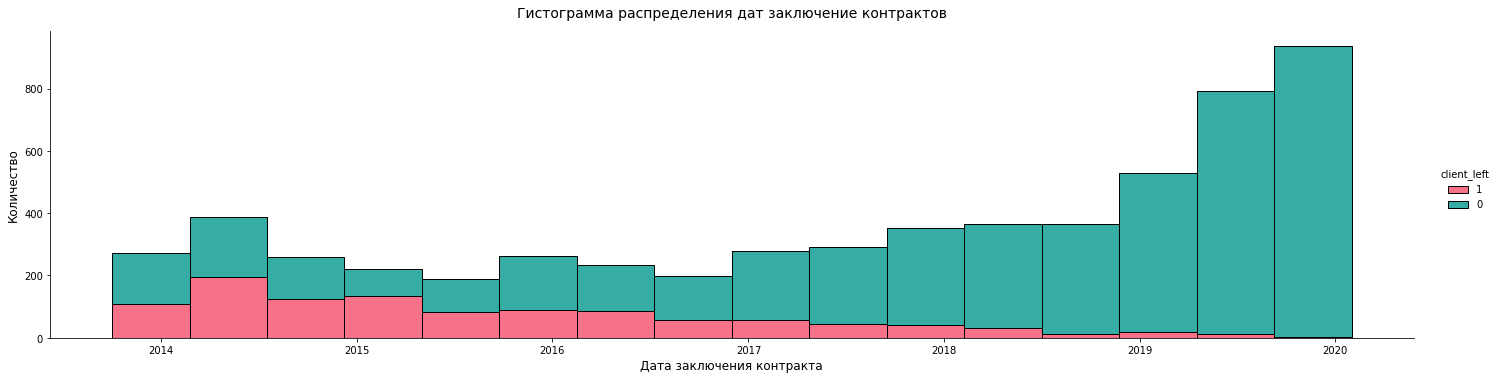

In [37]:
create_displot(contract, col_1 = 'begin_date', hue='client_left', hue_order = [1, 0],
               title='Гистограмма распределения дат заключение контрактов')

plt.xlabel('Дата заключения контракта', size=12)
plt.ylabel('Количество', size=12);

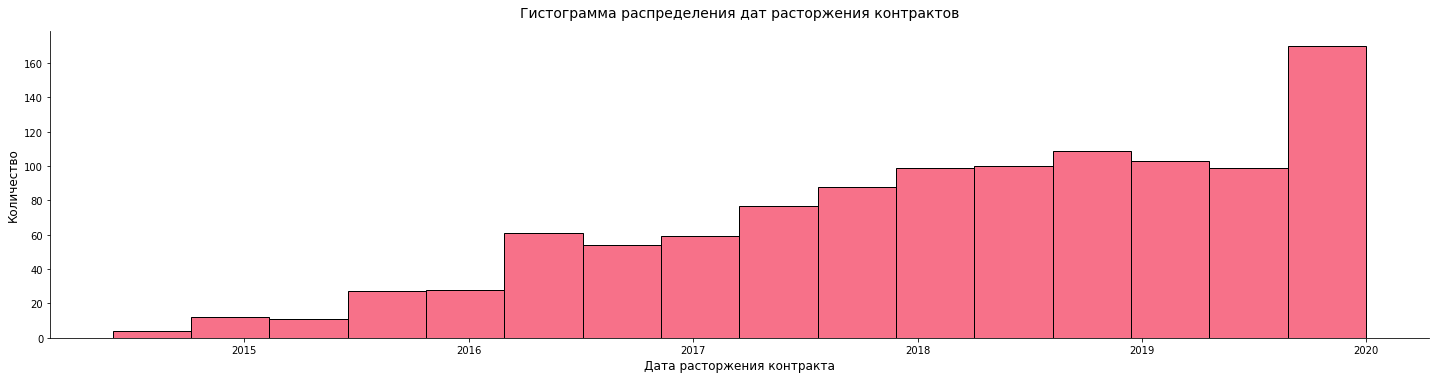

In [38]:
create_displot(contract, col_1 = 'end_date', hue='client_left', hue_order = [1, 0], legend=False,
               title='Гистограмма распределения дат расторжения контрактов')

plt.xlabel('Дата расторжения контракта', size=12)
plt.ylabel('Количество', size=12);

Изучим как меняется отношение разорванных контрактов к заключенным по годам

In [39]:
part_broken_contracts = pd.DataFrame(
    contract['end_date'].dt.year.value_counts() / contract['begin_date'].dt.year.value_counts(), columns = ['count']
)

Ignoring `palette` because no `hue` variable has been assigned.


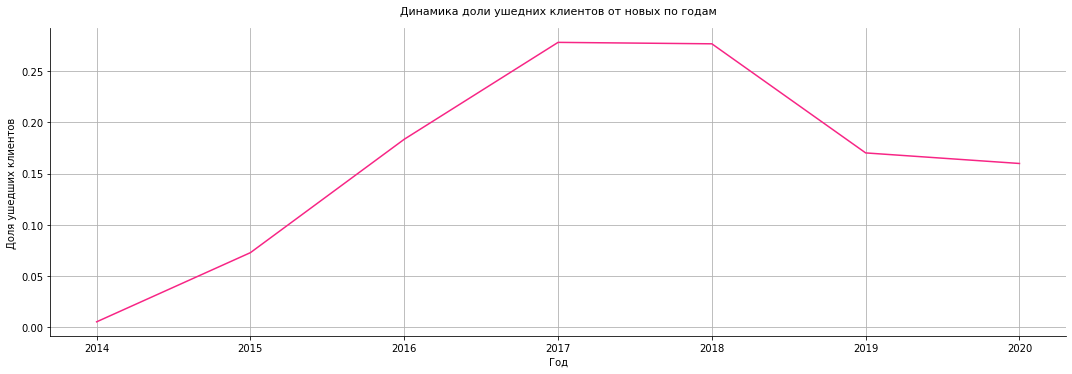

In [40]:
create_relplot(part_broken_contracts, col_1 = part_broken_contracts.index,
               col_2='count', kind='line', color='#F72585', title='Динамика доли ушедних клиентов от новых по годам')
plt.grid()
plt.xlabel('Год')
plt.ylabel('Доля ушедших клиентов');

- Примерно от половины до 2/3 клиентов, заключивших контракт с компаний в 2014-2016 годах, ушли.
- Из тех кто заключил контракт в последние 2 года, разорвала контракт лишь малая часть
- с 2014 до 2017 отношение ушедшних клиентов к новым росло, с 2017 по 2018 оставалось на одном уровне, а затем стало снижаться вплоть до 2020. 

#### Создадим новые признаки с продолжительностью контракта

Заполним пропуски в `end_date` датой, на которую актуальна информация о договорах

In [41]:
contract['end_date'] = contract['end_date'].fillna(contract['begin_date'].max())

In [42]:
contract['years_term'] = contract.apply(lambda row: relativedelta(row['end_date'], row['begin_date']).years, axis=1)

In [43]:
contract['total_days'] = (contract['end_date'] - contract['begin_date']).dt.days

In [44]:
contract['months_term'] = (
    contract.apply(lambda row: relativedelta(row['end_date'], row['begin_date']).months, axis=1) \
    + contract['years_term'] * 12
)

In [45]:
contract[['years_term', 'months_term']].describe().T

,count,mean,std,min,25%,50%,75%,max
years_term,7043.0,2.030527,1.869820,0.0,0.0,2.0,4.0,6.0
months_term,7043.0,29.495385,22.446726,0.0,9.0,25.0,48.0,76.0


In [46]:
contract.query('months_term == 0')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,client_left,years_term,total_days,months_term
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,0.0,0,0,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,0.0,0,0,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,0.0,0,0,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,0.0,0,0,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,0.0,0,0,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,0.0,0,0,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,0.0,0,0,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,0.0,0,0,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,0.0,0,0,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,0,Mailed check,73.35,0.0,0,0,0,0


Оставим для новых клиентов длительность контракта в месяцах равным 0.

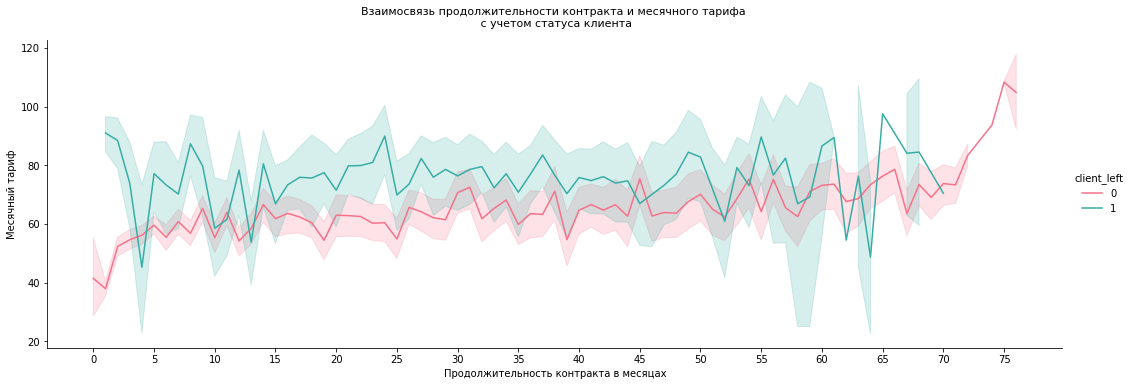

In [47]:
create_relplot(contract, col_1 = 'months_term', col_2 = 'monthly_charges',
               hue = 'client_left', palette='husl', title='Взаимосвязь продолжительности контракта и месячного тарифа \n с учетом статуса клиента')
plt.xticks(range(0, contract['months_term'].max() + 1, 5))
plt.ylabel('Месячный тариф')
plt.xlabel('Продолжительность контракта в месяцах');

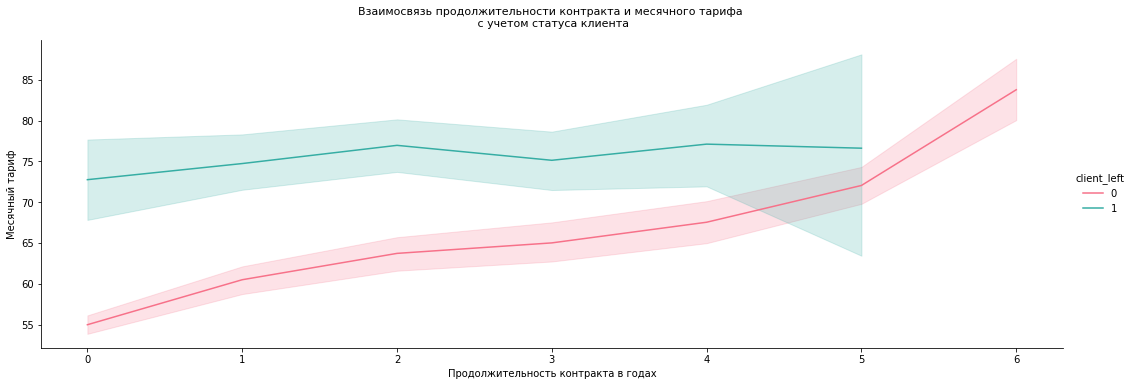

In [48]:
create_relplot(contract, col_1 = 'years_term', col_2 = 'monthly_charges',
               hue = 'client_left', palette='husl', title='Взаимосвязь продолжительности контракта и месячного тарифа \n с учетом статуса клиента')
plt.xticks(range(0, contract['years_term'].max() + 1, 1))
plt.ylabel('Месячный тариф')
plt.xlabel('Продолжительность контракта в годах');

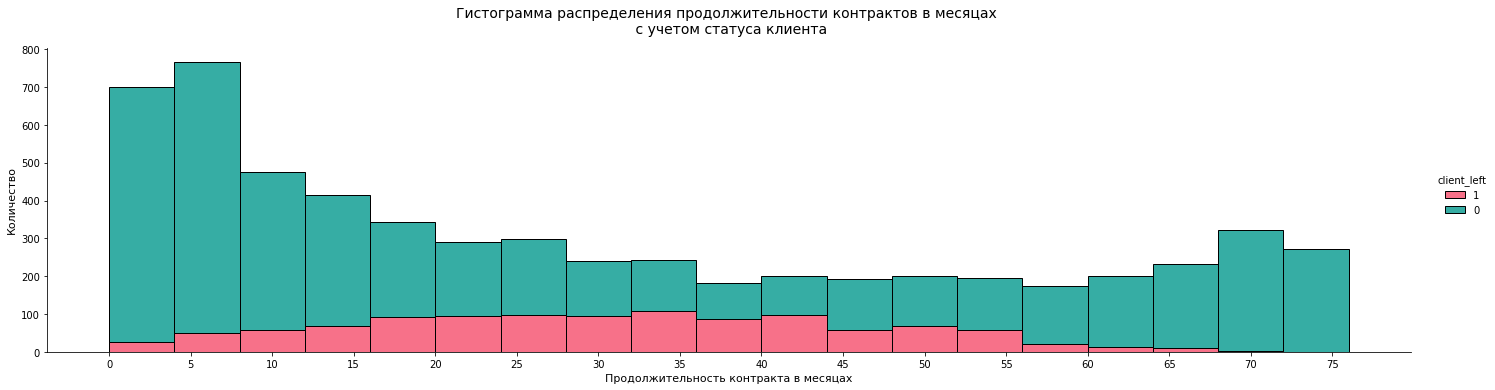

In [49]:
create_displot(contract, col_1 = 'months_term', hue='client_left', hue_order = [1, 0], palette='husl',
               title='Гистограмма распределения продолжительности контрактов в месяцах \n с учетом статуса клиента')
plt.xlabel('Продолжительность контракта в месяцах', size=11)
plt.ylabel('Количество',  size=11)
plt.xticks(range(0, contract['months_term'].max() + 1, 5));

Изучим, разрывали ли клиенты с оплатой раз в 1 или 2 года контракт раньше этого срока.

In [50]:
contract.query('((type == "One year" and months_term < 12) or (type == "Two year" and months_term < 24)) and client_left')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,client_left,years_term,total_days,months_term
15,3655-SNQYZ,2014-05-01,2016-03-01,Two year,0,Credit card (automatic),113.25,2491.50,1,1,670,22
165,6345-FZOQH,2014-05-01,2015-06-01,Two year,0,Mailed check,19.90,263.87,1,1,396,13
167,5997-OPVFA,2014-02-01,2015-06-01,Two year,1,Bank transfer (automatic),89.05,1424.80,1,1,485,16
226,6341-JVQGF,2017-07-01,2018-02-01,One year,1,Mailed check,81.15,579.41,1,0,215,7
268,6323-AYBRX,2015-02-01,2015-12-01,Two year,0,Mailed check,19.35,193.50,1,0,303,10
...,...,...,...,...,...,...,...,...,...,...,...,...
6785,3090-HAWSU,2014-10-01,2016-09-01,Two year,1,Credit card (automatic),111.60,2746.48,1,1,701,23
6813,0617-AQNWT,2014-07-01,2015-02-01,Two year,0,Electronic check,47.85,338.30,1,0,215,7
6918,8267-ZNYVZ,2017-02-01,2017-11-01,One year,1,Electronic check,103.75,1008.45,1,0,273,9
6941,2405-LBMUW,2015-01-01,2015-12-01,One year,1,Bank transfer (automatic),50.70,574.43,1,0,334,11


- Клиенты, разрывающие контракт в среднем начинают с более дорогих тарифов.
- Тарифы клиентов, разрывающих контракт, в среднем более дорогие вплоть до 5 лет действия контракта.
- Среди новых клиентов(до полутора лет) крайне невысока доля разрывающих контракт
- От трети до половины клиентов, у которых продолжительность контракта достигла 2-4 лет разрывают контракт
- Лишь незначительное количество клиентов сотрудничающих с компанией дольше 5 лет разрывают контракт.

#### Изучим как менялись тарифы клиентов

Так как `monthly_charges` указывает на последний или текущий тариф клиента, то имеет смысл рассчитать среднемесячные расходы клиентов, для сравнения их между собой и оценки динамики расходов клиентов.

In [51]:
contract['average_month_charges'] = contract['total_charges'] / contract['months_term']

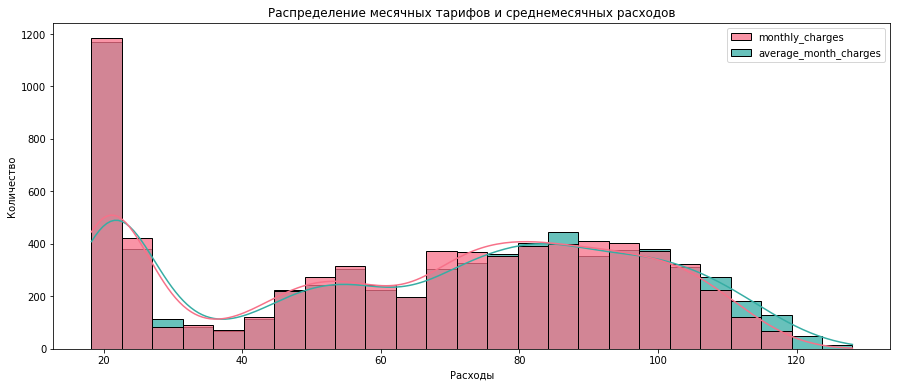

In [52]:
plt.figure(figsize=(15, 6))
sns.histplot(contract[['monthly_charges', 'average_month_charges']], kde=True, alpha=0.75,  palette='husl')
plt.title('Распределение месячных тарифов и среднемесячных расходов')
plt.xlabel('Расходы')
plt.ylabel('Количество');

In [53]:
contract['tariff_dynamics'] = (
    (contract['monthly_charges'] - contract['average_month_charges'])
    .apply(lambda x: 'increase' if x > 0 else 'decrease' if x < 0 else 'stable')
)

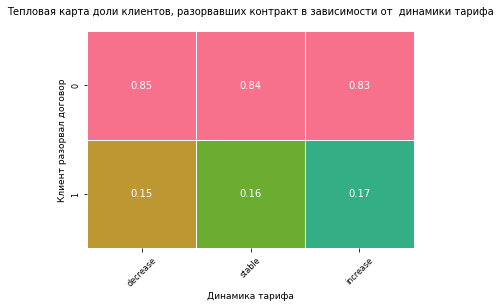

In [54]:
heatmap_crosstab(contract, 'client_left', 'tariff_dynamics', title='динамики тарифа',
                 xlabel='Динамика тарифа', vmax=0.2, vmin=0.14, sign=True);

Среди трех категорий клиентов процент разрыва контракта различается несущественно, однако, возможно в комбинации с другими признаками динамика тарифа поможет лучше разделить клиентов по целевому признаку

#### Проверим на наличие аномалий

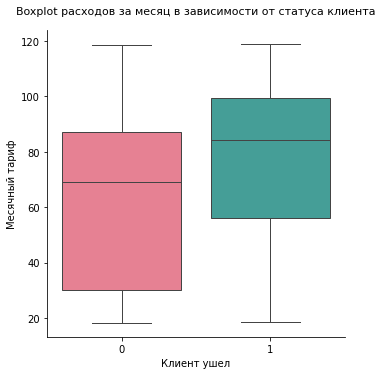

In [55]:
create_catplot(contract, col_1 = 'client_left' ,col_2 ='monthly_charges',
               title='Boxplot расходов за месяц в зависимости от статуса клиента')
plt.xlabel('Клиент ушел')
plt.ylabel('Месячный тариф');

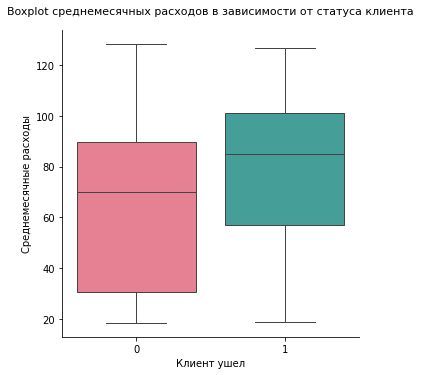

In [56]:
create_catplot(contract, col_1 = 'client_left' ,col_2 ='average_month_charges',
               title='Boxplot среднемесячных расходов в зависимости от статуса клиента')
plt.xlabel('Клиент ушел')
plt.ylabel('Среднемесячные расходы');

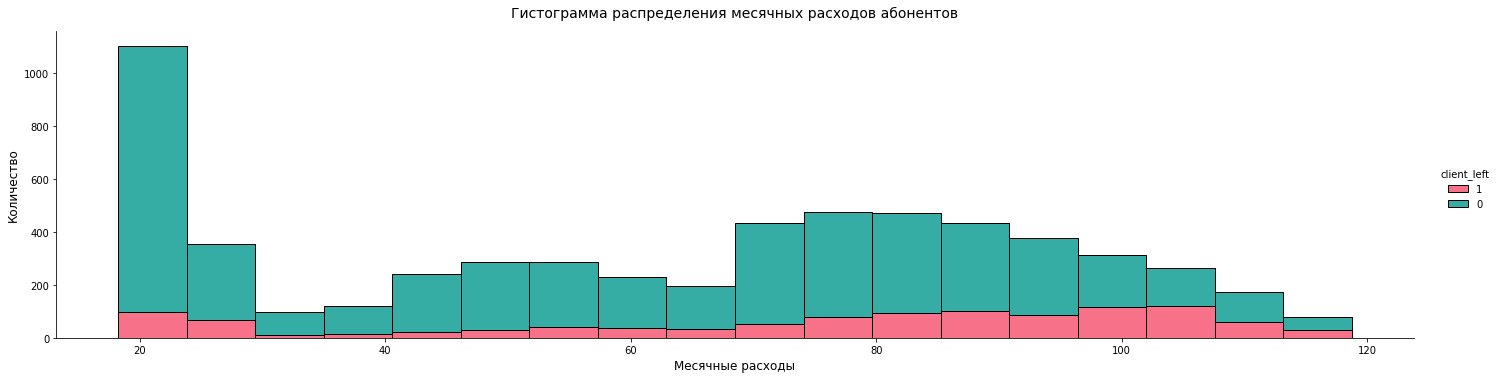

In [57]:
create_displot(contract, col_1 = 'monthly_charges', hue='client_left', hue_order = [1, 0],
               title='Гистограмма распределения месячных расходов абонентов')

plt.xlabel('Месячные расходы', size=12)
plt.ylabel('Количество', size=12);

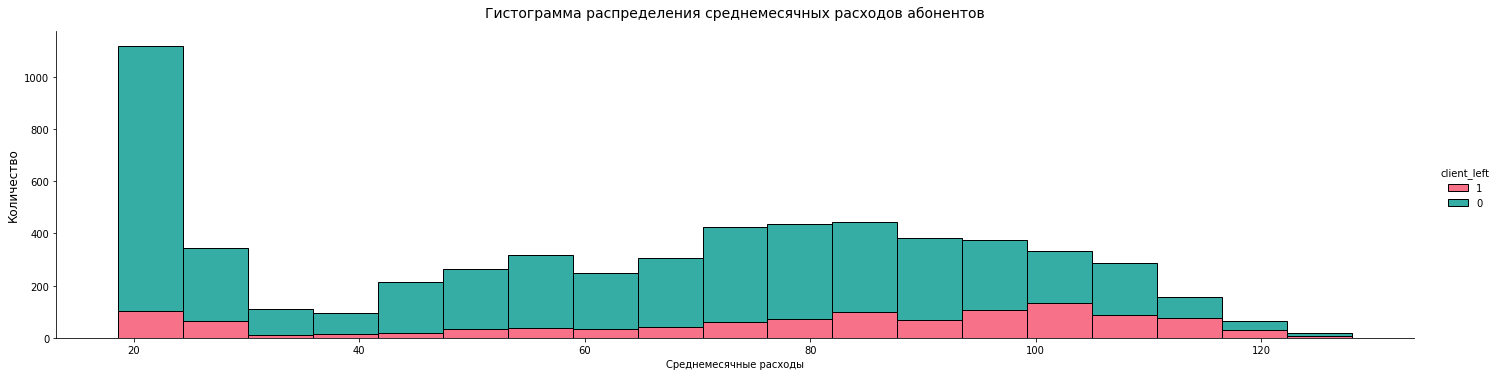

In [58]:
create_displot(contract, col_1 = 'average_month_charges', hue='client_left', hue_order = [1, 0],
               title='Гистограмма распределения среднемесячных расходов абонентов')

plt.xlabel('Среднемесячные расходы');
plt.ylabel('Количество', size=12);

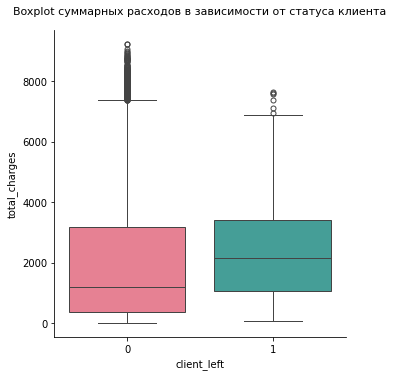

In [59]:
create_catplot(contract, col_1 = 'client_left', col_2 = 'total_charges',
               title='Boxplot суммарных расходов в зависимости от статуса клиента')

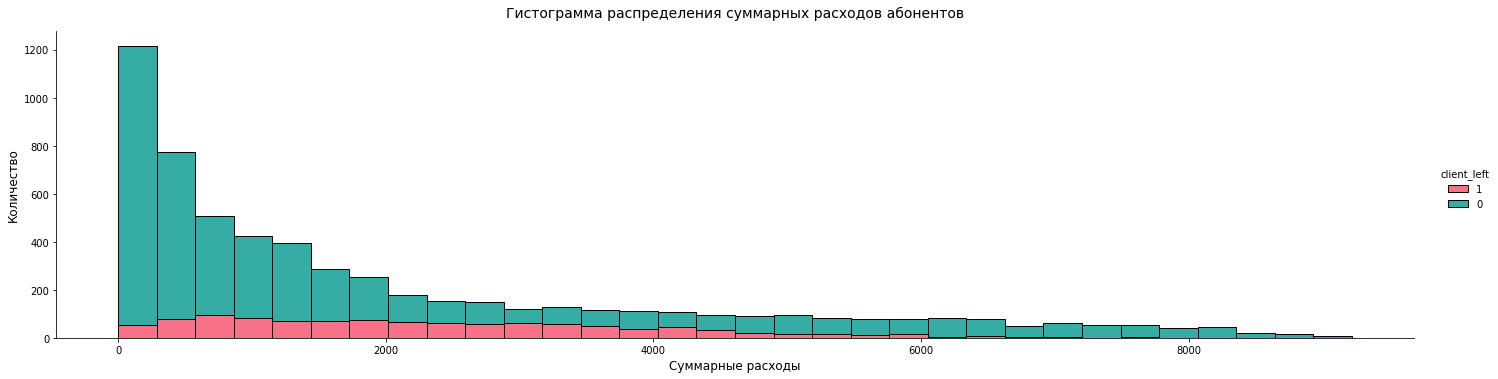

In [60]:
create_displot(contract, col_1 = 'total_charges', hue='client_left', hue_order = [1, 0],
               title='Гистограмма распределения суммарных расходов абонентов')

plt.xlabel('Суммарные расходы', size=12)
plt.ylabel('Количество', size=12);

**Распределение цены тарифов, среднемесячных и суммарных расходов выглядит реалистично:**

- Суммарные расходы имеют длинный хвост справа, максимальное значение - 9221.
- Среднемесячные расходы и цена тарифа имеют мультимодальный тип распределения, возможно, соответствующие разным категориям клиентов
- Мы убедились что, выбросы и аномальные значения не наблюдаются ни в одном из показателей.

#### Изучим распределение категориальных признаков

In [61]:
def multiplot(df, columns, col_num, titles, xlabel):
    fig, axes = plt.subplots(3, col_num, figsize=(30, 25),  gridspec_kw={'hspace': 0.5}, sharey='row')
    
    for i, column in enumerate(columns):
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)
            
            sns.countplot(data=df, x=column,  ax=axes[0, i], hue=None, palette='husl')
            sns.countplot(data=df, x=column,  ax=axes[1, i], hue='client_left', palette='husl')
            heatmap_crosstab(df, 'client_left', column, title='типа оплаты', vmax=0.29, center=0.15, vmin=0.07,
                             xlabel='Тип оплаты', ax=axes[2, i], cmap=sns.color_palette("husl", 2, as_cmap=True));   
            
            axes[0, i].set_title('Распределение клиентов по ' + titles[i], size=14)
            axes[1, i].set_title('Распределение клиентов по ' + titles[i] + '\n в зависимости от статуса', size=14, pad=16)
            axes[2, i].set_title('Доля клиентов разорвавших контракт, \nразделенные по ' + titles[i], size=14, pad=16)
            
            axes[0, i].set_xlabel(xlabel[i], size=12)
            axes[1, i].set_xlabel(xlabel[i], size=12)
            axes[2, i].set_xlabel(xlabel[i], size=12)
            
            axes[0, i].set_xticks(axes[0, i].get_xticks())
            axes[1, i].set_xticks(axes[1, i].get_xticks())
            axes[2, i].set_xticks(axes[2, i].get_xticks())
            
            axes[0, i].set_xticklabels(axes[0, i].get_xticklabels(), rotation=20, ha='right')
            axes[1, i].set_xticklabels(axes[1, i].get_xticklabels(), rotation=20, ha='right')
            axes[2, i].set_xticklabels(axes[2, i].get_xticklabels(), rotation=20, ha='right')
    
            axes[2, i].set_ylabel('', size=11);
    
            for patch in axes[0, i].patches:
                patch.set_edgecolor('black')  
                patch.set_linewidth(1.2)  
    
            for patch in axes[1, i].patches:
                patch.set_edgecolor('black')  
                patch.set_linewidth(1.2)  
            
            
    axes[0, 0].set_ylabel('Количество', size=11)
    axes[1, 0].set_ylabel('Количество', size=11)
    axes[2, 0].set_ylabel('Клиент ушел', size=11);

In [62]:
contract_titles = ['типу оплаты', 'запросу электронного расчетного листа ', 'методу оплаты']
contract_xlabel = ['Тип оплаты', 'Запрос электронного расчетного листа', 'Метод оплаты']
contract_cat = ['type', 'paperless_billing', 'payment_method']

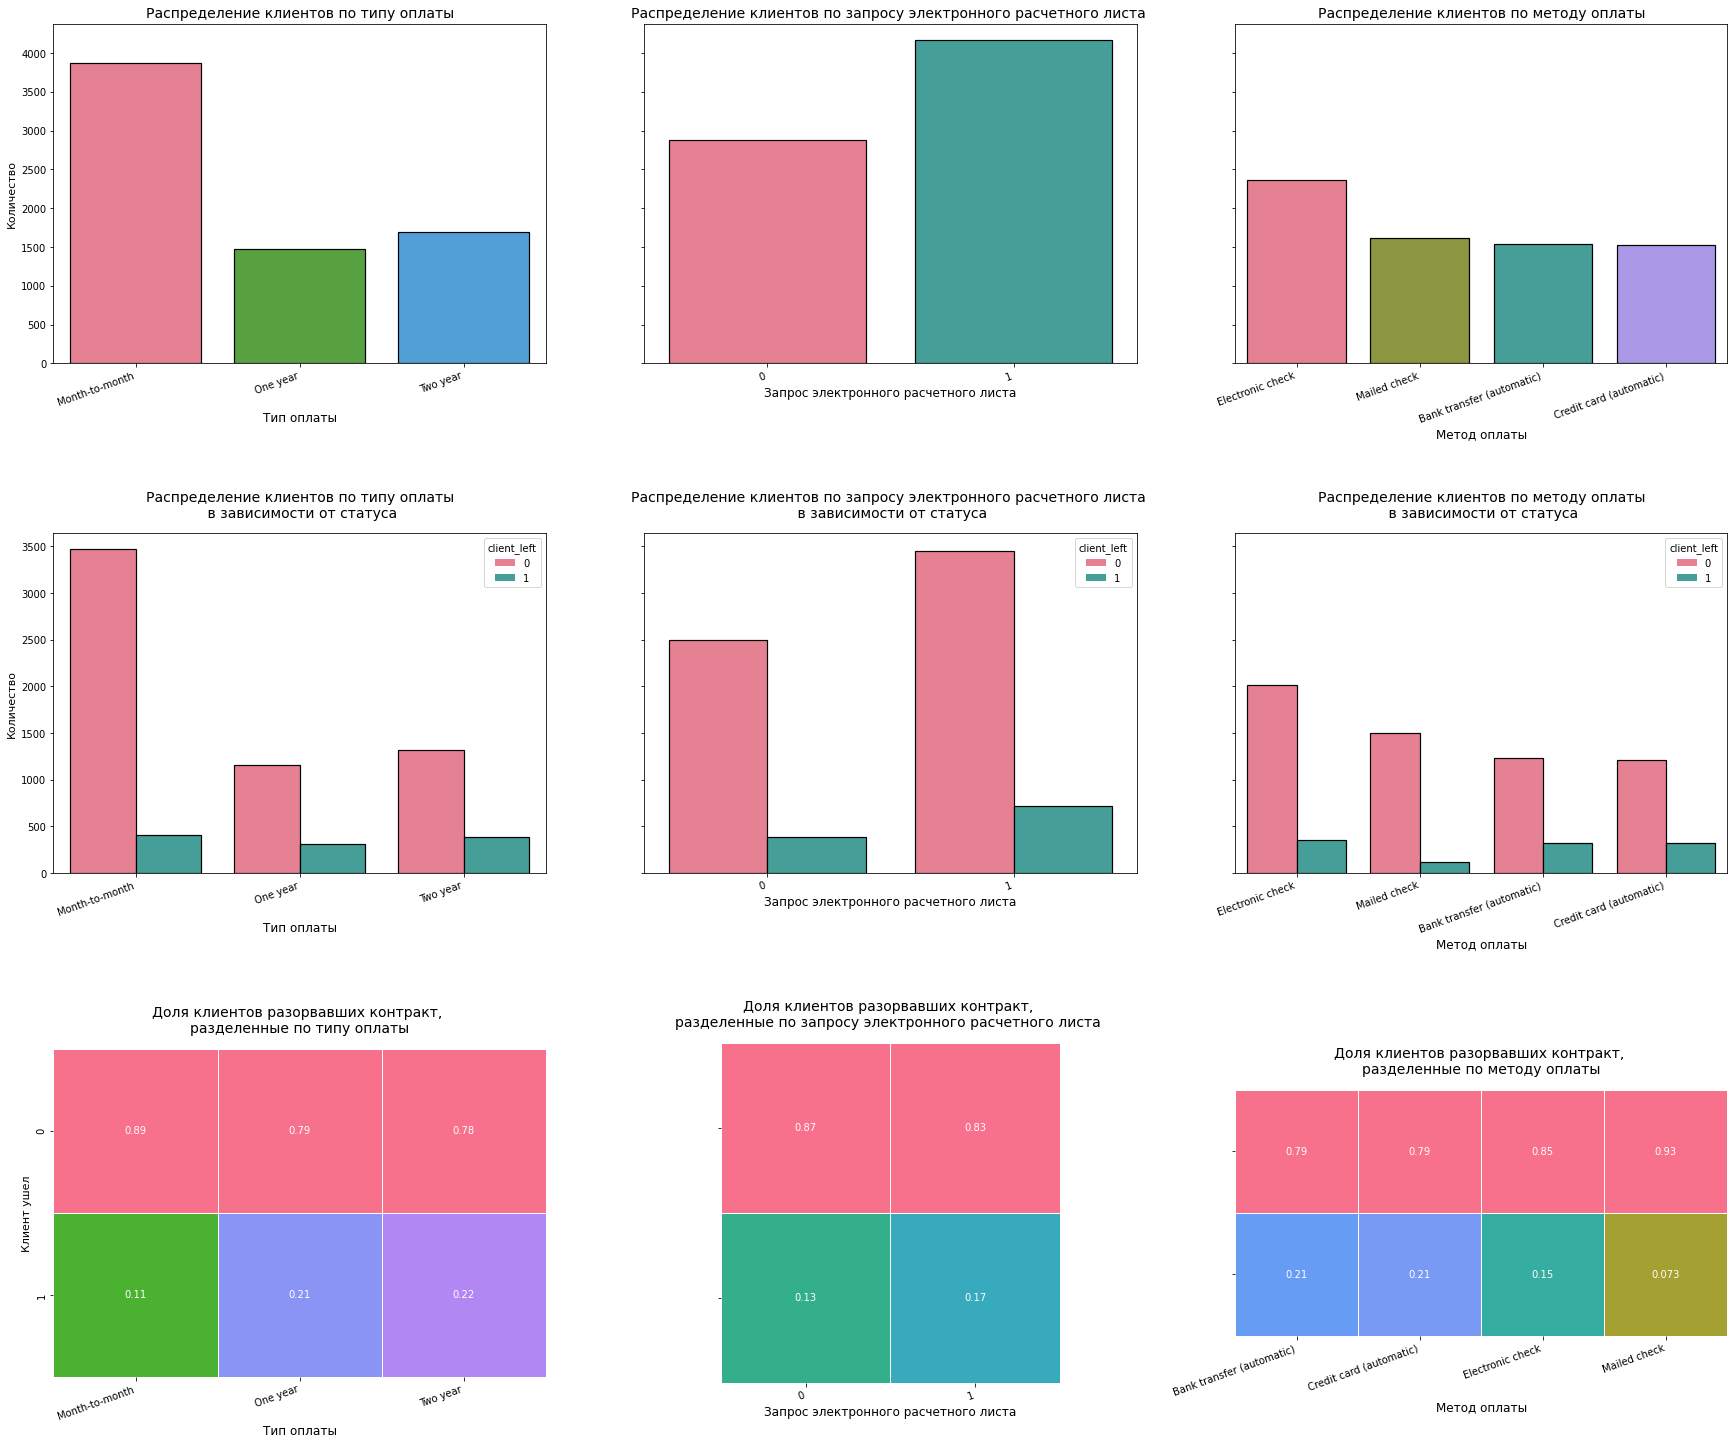

In [63]:
multiplot(contract, contract_cat, 3, contract_titles, contract_xlabel)

1. Тип оплаты
    * Клиентов с ежемесячной схемой оплаты столько же сколько и клиентов с годовой и двухлетней схемой
    * В абсолютном значении количество клиентов разорвавших контракт для всех 3 категорий схоже.
    * В относительном же значении, лишь 11% клиентов с ежемесячной схемой оплаты разорвали контракт, тогда как для двух других категорий этот процент составляет 21-22
2. Запрос электронного расчетного листа
   * Электронный чек предпочитает большее количество клиентов и они же немного чаще разрывают договор
3. Метод оплаты
   * Все методы оплаты пользуются сравнимой популярностью за исключением электронного платежа, он используется несколько большим количеством клиентов.
   * Абсолютное большинство клиентов, отправляющих чек по почте сохраняют договор с компанией - 93%. Возможно подобным методом оплаты пользуются клиенты пожилого возраста, менее склонные к смене операторов.
   * Среди клиентов использующих электронные переводы  процент разорвавших контракт меньше чем среди клиентов предпочитающих банковский переводы и кредитные карты, 15 против 21

In [64]:
type_and_methods = contract.pivot_table(index='type',
                     columns='payment_method',
                     values='client_left',
                     aggfunc='mean'
                    )

In [65]:
type_and_methods

payment_method,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
type,,,,
Month-to-month,0.144312,0.145488,0.115135,0.033595
One year,0.227621,0.241206,0.276657,0.094955
Two year,0.253546,0.244406,0.244048,0.143979


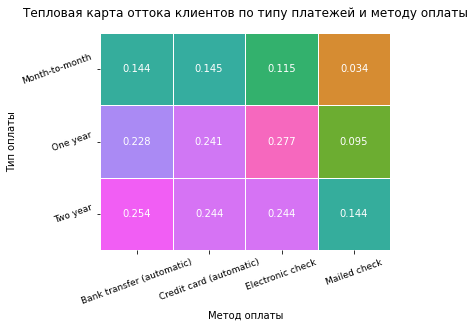

In [66]:
sns.heatmap(type_and_methods, annot=True, fmt=".3f", linewidths=1, vmax=0.28, vmin=0, center=0.15,
            cmap=sns.color_palette("husl", 4,as_cmap=True), square=True, cbar=False)
plt.title('Тепловая карта оттока клиентов по типу платежей и методу оплаты', pad=16)
plt.xticks(rotation=20, size=9)
plt.yticks(rotation=20, size=9)
plt.ylabel('Тип оплаты')
plt.xlabel('Метод оплаты');

Показатели нашего целевого признака для всех типов оплаты схожи у банковского платежа и оплаты кредитной <br>картой, объеденим эти два метода в один `nocash` и сгруппируем клиентов по комбинации методов и типов платежей - `payment_type_comb`

In [67]:
def type_payment_combination(row):
    
    type_mapping = {
        'Month-to-month': 'monthly',
        'One year': 'one_year',
        'Two year': 'two_year'
    }
    
    payment_mapping = {
        'Bank transfer (automatic)': 'no_cash',
        'Credit card (automatic)': 'no_cash',
        'Electronic check': 'electronic',
        'Mailed check': 'mailed'
    }

    type = type_mapping.get(row['type'], '')
    payment = payment_mapping.get(row['payment_method'], '')

    return f'{type}_{payment}'

In [68]:
contract['payment_type_comb'] = contract.apply(type_payment_combination, axis=1)

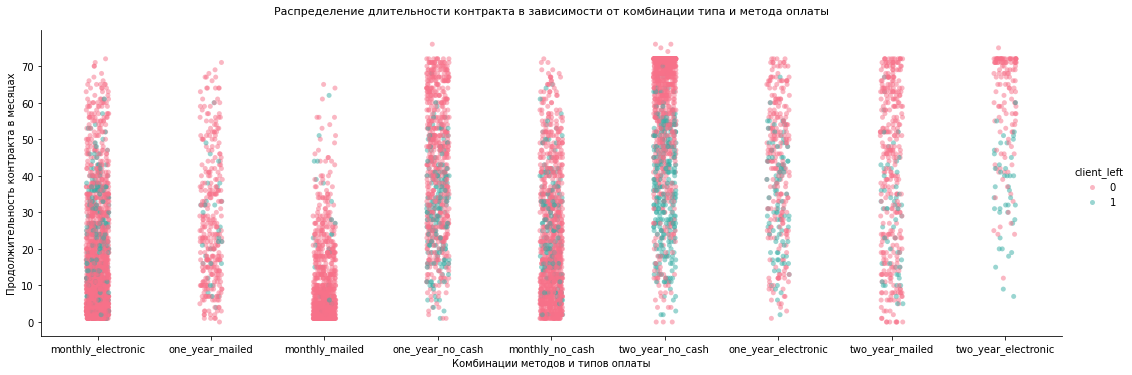

In [69]:
create_catplot(contract, col_1 = 'payment_type_comb', col_2 ='months_term', hue='client_left', kind='strip', legend=True,
               aspect=3, alpha=0.5, title='Распределение длительности контракта в зависимости от комбинации типа и метода оплаты')
plt.xlabel('Комбинации методов и типов оплаты', size=10)
plt.ylabel('Продолжительность контракта в месяцах', size=10);

- Клиенты оплачивающие раз в два года с помощью `electronic` и `no_cash`и сотрудничающие с компанией менее 5 лет очень часто разрывают контракт

- Теперь у нас есть признак со статусом клиента и признаки с продолжительностью контракта, `end_date` можно отбросить.
- Признак содержащий информацию о начале договора вкупе с информацией о продолжительности договора вызовет утечку информации, поэтому также избавимся от `begin_date`
- Среднемесячные расходы коррелируют с ценой тарифа и суммарными расходами и являются лишним признаком

In [70]:
contract = contract.drop(['end_date', 'begin_date', 'average_month_charges'],  axis=1)

#### Промежуточный вывод

**Произвели предобработку и исследование датафрейма `contract` с данными о контраках клиентов**

1. Целевой признак:
    - Создан целевой признак client_left на основе столбца end_date с двумя значениями:<br> 1 (Клиент разорвал договор) и 0 (Клиент остается активным).
2. Преобразование данных:
    - Приведены признаки с датами к типу данных datetime.
    - Суммарные расходы приведены к числовому типу после избавления от пустых значений 
    - Бинарные признаки приведены к циелочисленному типу
3. Исследование:
    - Анализ временной динамики оттока клиентов показал, что примерно от половины до 2/3 клиентов,<br> заключивших контракт с компанией в 2014-2016 годах, ушли. В 2017 - 2018 годах отношение ушедших клиентов к новым стабилизировалось, а после стало снижаться вплоть до 2020.
   - Средние ежемесячные расходы клиентов, разрывающих контракт, в среднем выше, особенно в начале срока действия контракта.
   - Среди клиентов с продолжительностью контракта от 2 до 4 лет наблюдается наибольший процент разрыва контракта.
   - Визуальный анализ распределения цены тарифов, среднемесячных и суммарных расходов показал реалистичное распределение без аномальных значений.
   - Осмотр признаков, связанных с типом оплаты, электронным расчетным листом и методами оплаты, <br> позволил выявить некоторые тенденции в поведении клиентов. Эти признаки могут помочь модели лучше разделять клиентов по целевому признаку
4. Новые признаки:
   - Сравнив последний актуальный тариф со среднемесячными расходами клиентов, разделили их на три категории <br> в зависимости от динамики цены тарифа - `tariff_dynamics`
   - Высчитали продолжительность контрактов клиентов в годах и месяцах - `years_term` и `months_term`
5. Лишние признаки:
   - Признаки `begin_date` и `end_date` исключены из рассмотрения, чтобы избежать утечки информации.
   - Среднемесячные расходы явно коррелируют с ценой тарифа, являются избыточным признаком и также исключены
  
**Предварительная обработка данных проведена успешно, исследование позволило изучить распределение признаков самих по себе,<br> а также относительно целевого. Были созданы новые признаки, важные для дальнейшего анализа и построения модели.**

### Personal

In [71]:
personal.sample(5)

,customer_id,gender,senior_citizen,partner,dependents
4468,7083-YNSKY,Female,0,No,No
3620,9373-WSLOY,Male,1,Yes,No
5302,9700-ISPUP,Female,0,Yes,Yes
2302,7579-KKLOE,Male,0,Yes,Yes
2125,8311-UEUAB,Female,0,Yes,Yes


**Пояснение столбцов**

* `customer_id` — идентификатор абонента;
* `gender` — пол;
* `senior_citizen` — является ли абонент пенсионером;
* `partner` — есть ли у абонента супруг или супруга;
* `dependents` — есть ли у абонента дети;

In [72]:
personal.dtypes

customer_id       object
gender            object
senior_citizen     int64
partner           object
dependents        object
dtype: object

In [73]:
personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [74]:
personal.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,7043,7043,6048-UWKAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
senior_citizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Изменим тип данных у столбцов

In [75]:
for col in personal.iloc[:, 2:].columns:
    personal[col] = personal[col].apply(binary_encode)

In [76]:
personal['gender'] = personal['gender'].replace({'Female' : 0, 'Male' : 1})
personal.rename(columns={'gender' : 'is_male'}, inplace=True)

In [77]:
personal.dtypes

customer_id       object
is_male            int64
senior_citizen     int64
partner            int64
dependents         int64
dtype: object

In [78]:
personal.sample(5)

,customer_id,is_male,senior_citizen,partner,dependents
3005,0516-QREYC,0,1,0,0
5485,7794-JASDG,1,0,0,0
488,4472-LVYGI,0,0,1,1
6402,8510-TMWYB,0,0,1,1
1403,2373-NTKOD,1,0,0,0


#### Изучим распределение категориальных признаков

In [79]:
personal = pd.merge(personal, target, on='customer_id', how='outer')

In [80]:
personal_cat = ['is_male', 'senior_citizen', 'partner', 'dependents']
personal_titles = ['полу', 'пенсионному статусу', 'наличию супруга/супруги', 'наличию детей']
personal_xlabel= ['Клиент мужчина', 'Пенсионный статус', 'В браке', 'Есть дети']

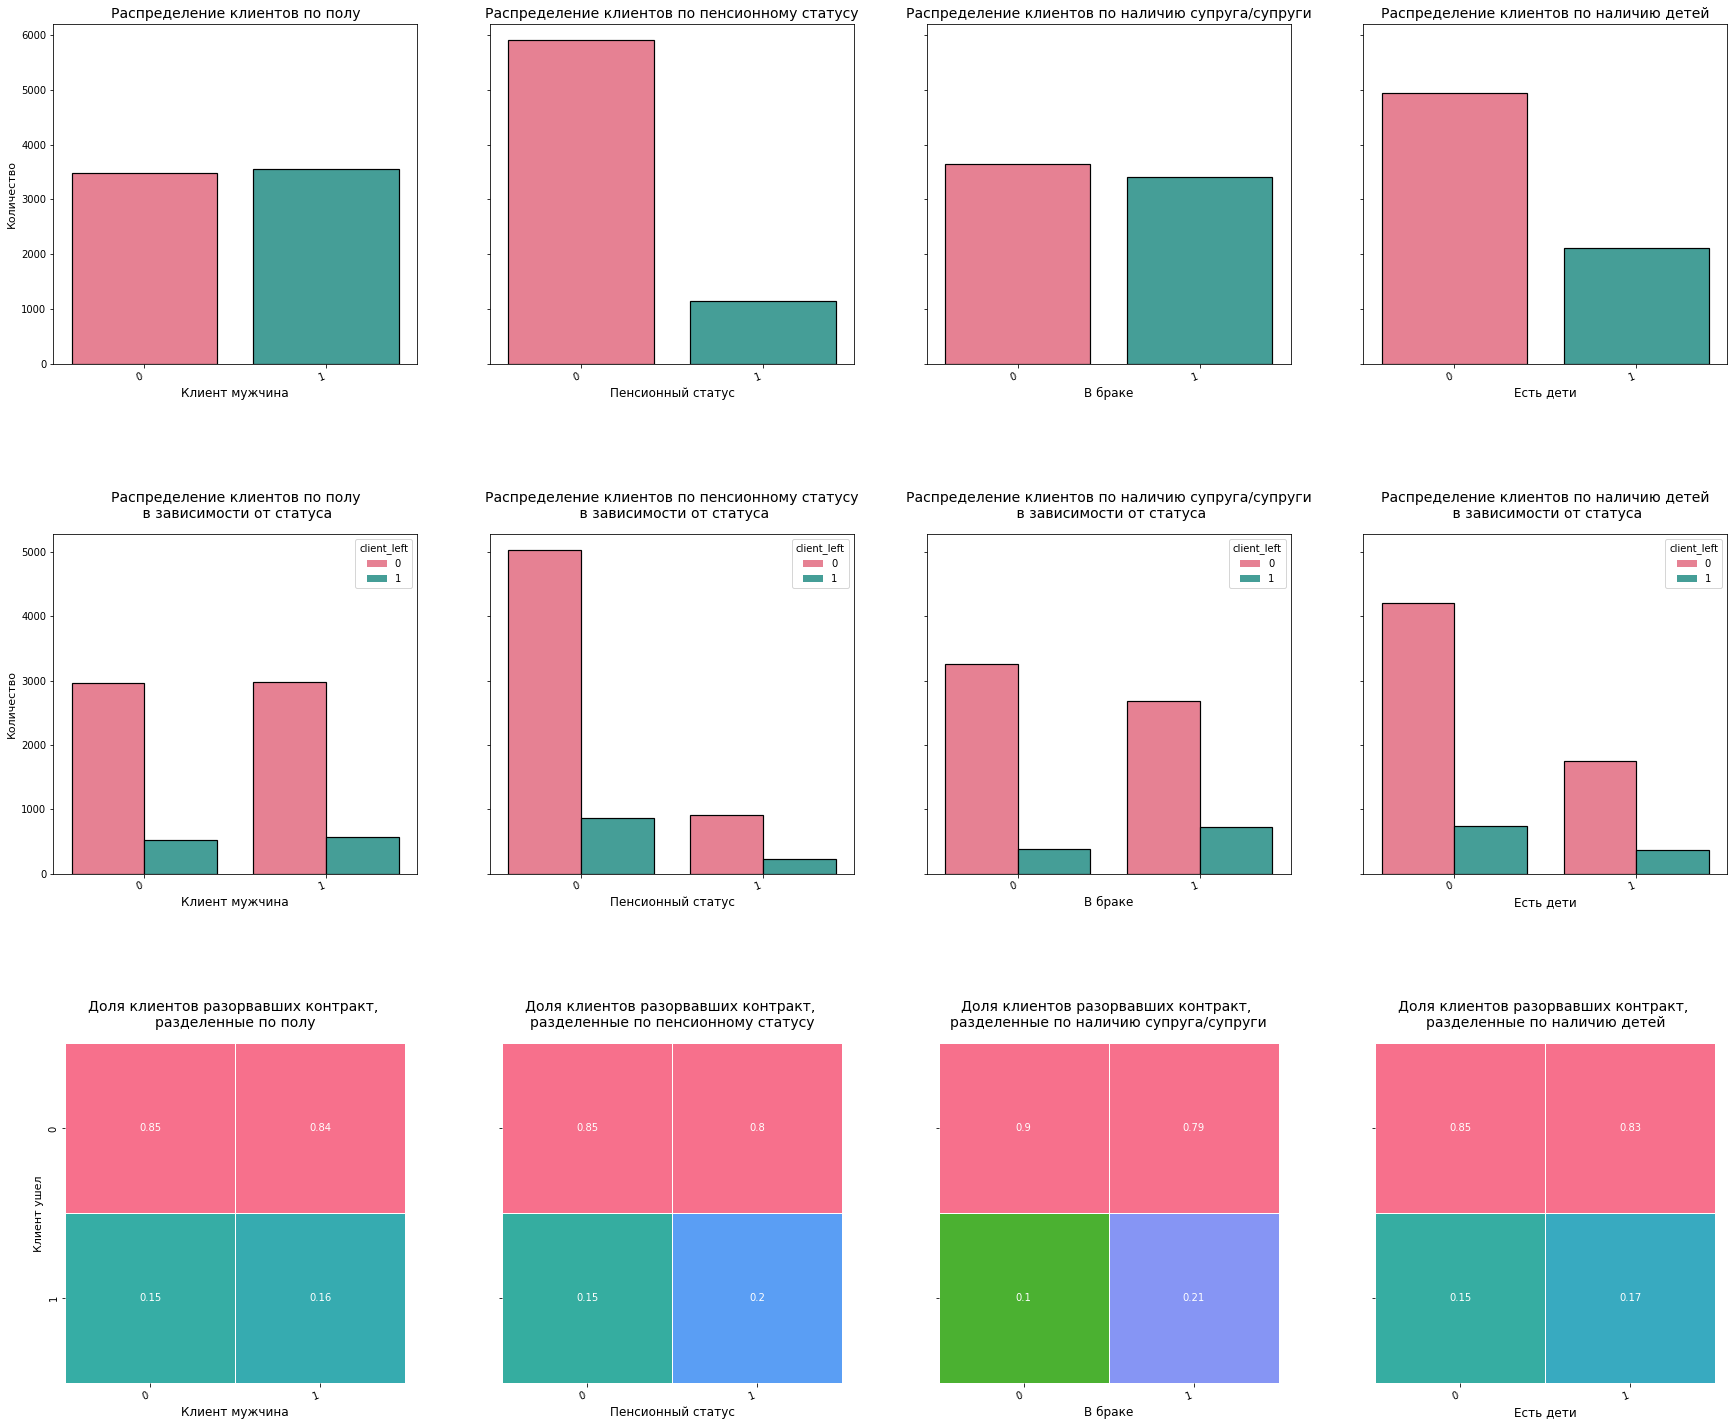

In [81]:
multiplot(personal, personal_cat, 4, personal_titles, personal_xlabel)

- Мужчин и женщин, а так же состоящих и не состоящих в браке среди клиентов примерно поровну
- Менее трети имеют детей или только около 1/10 являются пенсионерами
- Показательно, что среди пенсионеров договор разорвало 20%, а среди клиентов не достигших <br>
пенсионного возраста  лишь 15, что опровергает нашу гипотезу касательно тех, кто выбирает `mailed_check`
- Существенную разница в распределении целевого признака наблюдается лишь в браке - клиенты, <br> состоящие в нем разрывают контракт в два раза чаще чем те, кто не состоит - 21% против 10%

Сгруппируем клиентов по их семейному статусу:
  - Если клиент состоит в браке и имеет детей, его семейный статус устанавливается как `full`.
  - Если клиент состоит в браке, но не имеет детей, семейный статус устанавливается как `marriage`.
  - Если клиент не состоит в браке и не имеет детей, семейный статус устанавливается как `single`.
  - Если клиент не состоит в браке, но имеет детей, семейный статус устанавливается как `solo parent`.

В случае, если значения столбцов `partner` и `dependents` не соответствуют ни одному из вышеперечисленных условий, возвращается значение `Не определено`.

In [82]:
def get_family_status(row):
    
    if row['partner'] and row['dependents']:
        return 'full'
    elif row['partner'] and not row['dependents']:
        return 'marriage'
    elif not row['partner'] and not row['dependents']:
        return 'single'
    elif not row['partner'] and row['dependents']:
        return 'solo parent'
    else:
        return 'Не определено'

In [83]:
personal['family_status'] = personal.apply(get_family_status, axis=1)

Изучим как распределяются клиенты по семейному статусу с учетом целевого признака

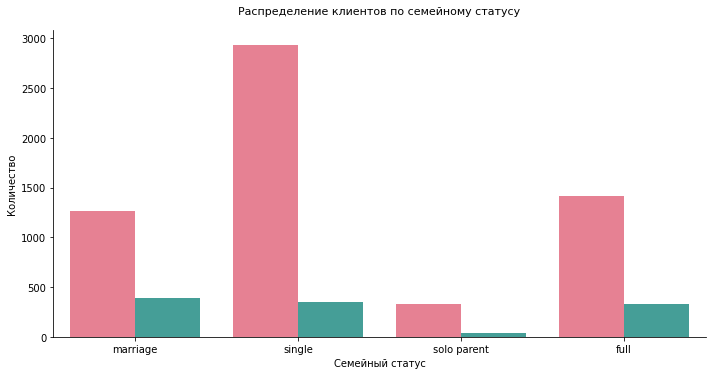

In [84]:
create_catplot(personal, col_1 = 'family_status', kind='count', aspect=2,
              hue='client_left', legend=False, title='Распределение клиентов по семейному статусу')
plt.xlabel('Семейный статус')
plt.ylabel('Количество');

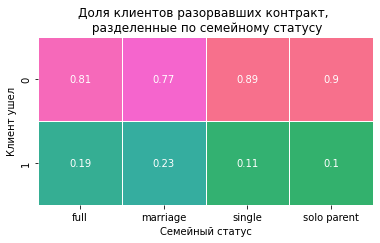

In [85]:
heatmap_crosstab(personal, 'client_left', 'family_status',
                vmax=0.9, vmin=0.1, center=0.25)
plt.title('Доля клиентов разорвавших контракт, \n разделенные по семейному статусу', size=12)
plt.xlabel('Семейный статус')
plt.ylabel('Клиент ушел');

- Большая часть клиентов не состоят в браке и не имеют детей
- Клиентов в браке и клиентов с полной семьей сравнимое количество
- Процент разрыва контракта у одиноких клиентов и родителей-одиночек в два раза меньше, <br> чем у клиентов в браке или с полной семьей, 11-10 % против  23-19%

#### Промежуточный вывод

**Произвели предобработку и исследование датафрейма `personal` с персональной информацией клиентов**

1. Были преобразованы столбцы `senior_citizen`, `partner`, и `dependents` в целочисленный тип данных со значениями 1 и 0. Столбец `gender` переименован в `is_male` со значениями 1 и 0.
2. Анализ распределения по полу, семейному положению, наличию детей и пенсионному статусу показал, что:
    - Клиенты примерно равномерны распределены по полу и семейному положению
    - Клиенты с детьми составляют менее трети от общего числа клиентов
    - Около 10% клиентов являются пенсионерами.
3. Наблюдается различие в проценте разрыва контракта между клиентами, состоящими в браке и теми, кто не состоит в браке.<br> Клиенты в браке чаще разрывают контракт (21% против 10%). Это может быть важным признаком для прогнозирования оттока клиентов.
4. Была проведена группировка клиентов по семейному статусу(семейное положение + наличие детей) и изучено распределение клиентов по этому признаку
    - Большинство клиентов не состоят в браке и не имеют детей.
    - Количество клиентов в браке и с полной семьей схоже.
    - Процент разрыва контракта у одиноких клиентов и родителей-одиночек в два раза меньше, чем у клиентов в браке или с полной семьей.
  
**Семейный статус является важным фактором в анализе оттока клиентов. Одинокие клиенты и родители-одиночки <br> более склонны к сохранению контракта, чем клиенты, состоящие в браке или с полной семьей. Для стратегий удержания клиентов стоит уделить внимание этому фактору.**

### Internet и Phone

#### Объеденим датафреймы с услугами в один

In [86]:
services = pd.merge(internet, phone, on='customer_id', how='outer')

In [87]:
services.shape

(7043, 9)

In [88]:
services.sample(5)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
5605,4785-FCIFB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1669,9779-DPNEJ,Fiber optic,No,No,No,No,No,Yes,No
3585,4658-HCOHW,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,No
2365,6127-ISGTU,Fiber optic,No,No,No,No,Yes,No,Yes
765,0851-DFJKB,DSL,Yes,No,Yes,Yes,No,No,No


**Пояснение столбцов**

* `customer_id` — идентификатор абонента;
* `InternetService` — тип подключения;
* `OnlineSecurity` — блокировка опасных сайтов;
* `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
* `DeviceProtection` — антивирус;
* `TechSupport` — выделенная линия технической поддержки;
* `StreamingTV` — стриминговое телевидение;
* `StreamingMovies` — каталог фильмов.
* `MultipleLines` — подключение телефона к нескольким линиям одновременно.

#### Добавим целевой признак

In [89]:
services = pd.merge(services, target, on='customer_id', how='outer')

#### Распределим клиентов по группам в зависимости от выбранных основных услуг

Создадим новый признак `basic_service` для указания какими из базовых услуг пользуется клиент:

 - `internet`
 - `phone`
 - `both`

In [90]:
services.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,No,0


Проверим столбцы `internet_service` и `multiple_lines`, если клиенты не пользовались одной из двух базовых услуг, то при соединении таблиц на месте не выбранной услуги появлися пропуск.

In [91]:
services['basic_service'] = services.apply(
    lambda row: 'internet' if pd.isna(
        row['multiple_lines']
    ) else 'phone' if pd.isna(
        row['internet_service']
    ) else 'both',
    axis=1)

#### Подсчитаем количество подключенных клиентом интернет-услуг

In [92]:
services['internet_service_number'] = services[services.columns[2:8]].eq('Yes').sum(axis=1)

In [93]:
services.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,basic_service,internet_service_number
0,7590-VHVEG,DSL,No,Yes,No,No,No,No,NaN,0,internet,1
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No,No,0,both,2
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No,No,0,both,2
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No,NaN,0,internet,3
4,9237-HQITU,Fiber optic,No,No,No,No,No,No,No,0,both,0


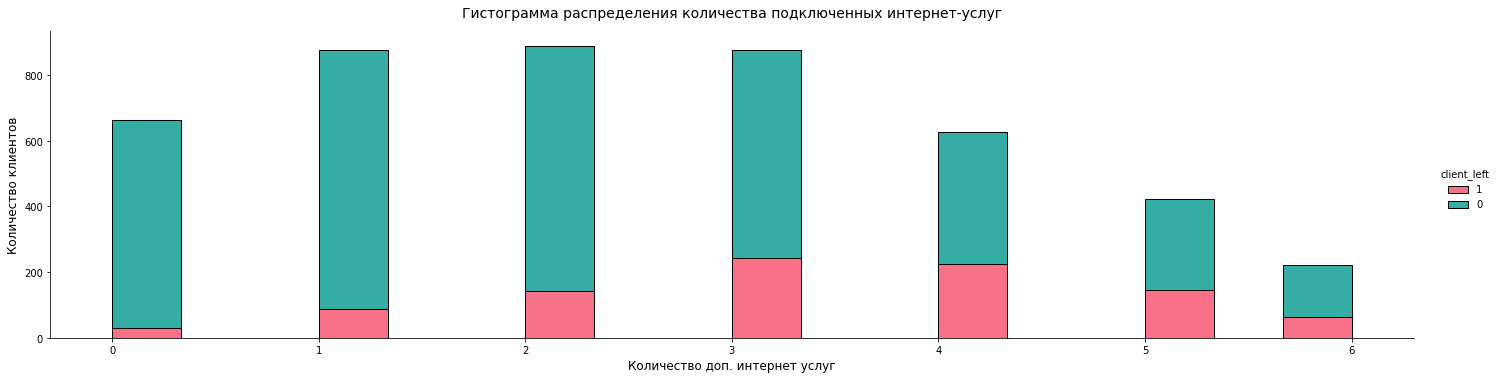

In [94]:
create_displot(services.query('basic_service != "phone"'), col_1 = 'internet_service_number', hue='client_left', hue_order = [1, 0],
               title='Гистограмма распределения количества подключенных интернет-услуг')

plt.xlabel('Количество доп. интернет услуг', size=12)
plt.ylabel('Количество клиентов', size=12);

In [95]:
services.query('basic_service != "phone"')['internet_service_number'].describe()

count    5517.000000
mean        2.601595
std         1.700483
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: internet_service_number, dtype: float64

- Половина всех интернет-клиентов подключают 1-4 услуги
- Клиенты с большим количеством услуг более склонны разрывать контракт

Прежде чем заполнять пропуски, изучим распределение выбранных услуг клиентами.

#### Изучим распределение признаков

In [96]:
services.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,7043,7043,6048-UWKAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
internet_service,5517,2,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
online_security,5517,2,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN
online_backup,5517,2,No,3088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_protection,5517,2,No,3095,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tech_support,5517,2,No,3473,NaN,NaN,NaN,NaN,NaN,NaN,NaN
streaming_tv,5517,2,No,2810,NaN,NaN,NaN,NaN,NaN,NaN,NaN
streaming_movies,5517,2,No,2785,NaN,NaN,NaN,NaN,NaN,NaN,NaN
multiple_lines,6361,2,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
client_left,7043.0,NaN,NaN,NaN,0.156325,0.363189,0.0,0.0,0.0,0.0,1.0


In [97]:
internet_services = ['online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']

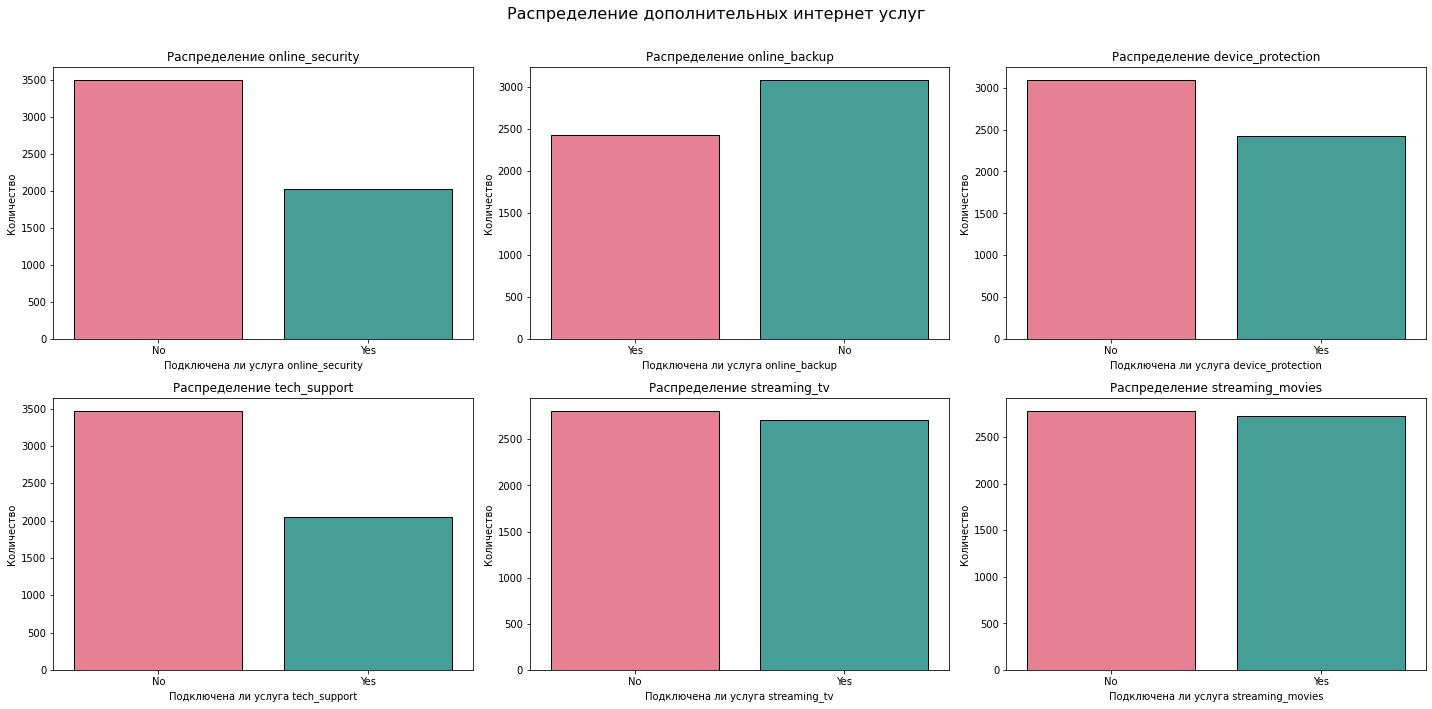

In [98]:
fig = plt.figure(figsize=(20, 10))

for i, column in enumerate(internet_services, start=1):
    ax = plt.subplot(2, 3, i)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        sns.countplot(data=services.query('basic_service != "phone"'), x=column, ax=ax, hue=None, palette='husl', edgecolor='black', linewidth=1)
    
    ax.set_title(f'Распределение {column}')
    ax.set_xlabel(f'Подключена ли услуга {column}')
    ax.set_ylabel('Количество')
    
fig.suptitle('Распределение дополнительных интернет услуг', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.97])


- Услуги стримингового телевидения и каталог фильмов подключают около половины подключивших интернет, остальные услуги пользуются меньшей популярностью.

In [99]:
services_col = ['basic_service', 'internet_service', 'multiple_lines']
services_title = ['выбору основных услуг', 'выбору типа подключения интернета', 'подключению мультилинии']
services_xlabel = ['Выбранные основные услуги', 'Тип подключения', 'Мультилиния подключена']

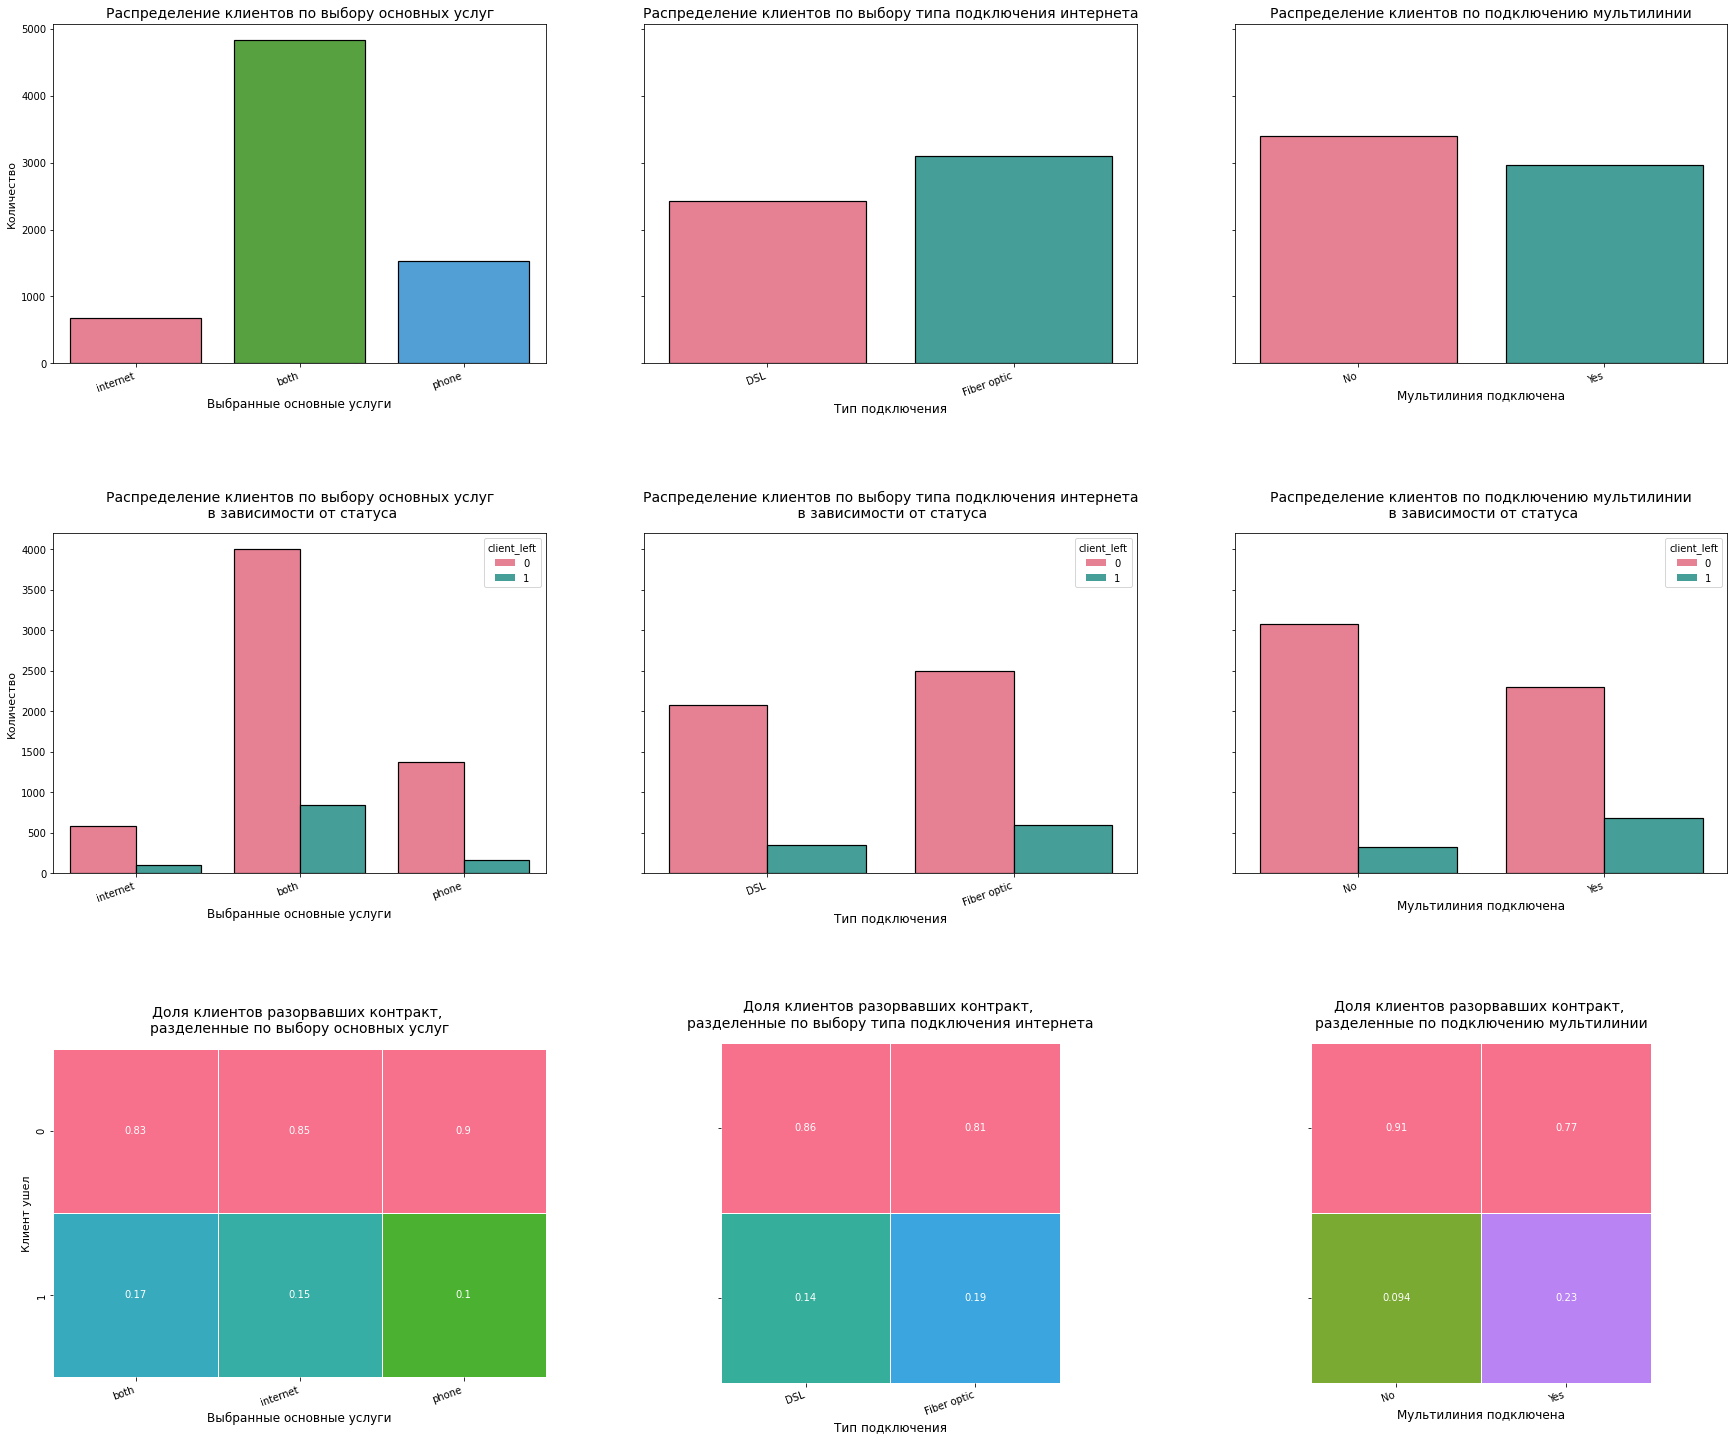

In [100]:
multiplot(services, services_col, 3, services_title, services_xlabel)

- Большинство клиентов подключает обе основные услуги - и интернет, и телефон. Меньше всего выбирают только интернет.
- Немного больше клиенты отдают предпочтение оптоволокну, так же несколько большее число клиентов отказывается от мультилиний
- Клиенты пользующиейся услугами только телефонии реже других разрывают договор, среди тех, <br> кто при этом не подключает мультилинии договор сохранило 91% клиентов

#### Заполним пропуски и изменим типы данных

In [101]:
services.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   customer_id              7043 non-null   object
 1   internet_service         5517 non-null   object
 2   online_security          5517 non-null   object
 3   online_backup            5517 non-null   object
 4   device_protection        5517 non-null   object
 5   tech_support             5517 non-null   object
 6   streaming_tv             5517 non-null   object
 7   streaming_movies         5517 non-null   object
 8   multiple_lines           6361 non-null   object
 9   client_left              7043 non-null   int64 
 10  basic_service            7043 non-null   object
 11  internet_service_number  7043 non-null   int64 
dtypes: int64(2), object(10)
memory usage: 973.3+ KB


In [102]:
services.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'client_left', 'basic_service',
       'internet_service_number'],
      dtype='object')

In [103]:
col_to_fill = ['online_security', 'online_backup','device_protection',
               'tech_support', 'streaming_tv', 'streaming_movies']

In [104]:
services[col_to_fill] = services[col_to_fill].fillna(False)
services['internet_service'] = services['internet_service'].fillna('No')
services['multiple_lines'] = services['multiple_lines'].fillna('No phone')

In [105]:
for col in col_to_fill:
    services[col] = services[col].apply(binary_encode)

In [106]:
services.sample(5)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_left,basic_service,internet_service_number
1180,0743-HNPFG,DSL,1,1,0,1,0,1,No,0,both,4
5150,3205-MXZRA,DSL,0,0,0,1,1,0,No,0,both,2
1544,3948-XHGNA,DSL,1,0,0,0,0,0,No,0,both,1
6423,6248-BSHKG,No,0,0,0,0,0,0,No,0,phone,0
2742,1335-NTIUC,DSL,0,0,0,0,0,0,No phone,0,internet,0


#### Промежуточный вывод

**Произвели предобработку и исследование объединенных датафреймов `internet` и `phone` с информацией о выбранных услугах**

1. Распределили клиентов по 3 категориям, в зависимости от выбранных основных услуг.
2. Подсчитали количество подключенных интернет услуг и изучили распределение
   - Половина всех интернет-клиентов подключают 1-4 услуги
   - Клиенты с большим количеством подключенных услуг склонны чаще разрывать контракт
4. Визуализировали и изучили выбор доп. интернет услуг
   - Стриминговый сервис и каталог фильмов наиболее популярные.
   - Остальные услуги выбираются с примерно равной частотой
5. Визуализировали предпочтения клиентов в выборе основных услуг, типа подключения интернета и выбор мультилинии.
   - Наиболее частый выбор - и интернет, и телефония. Наименее - только интернет
   - Оптоволокно - более предпочтительный вариант, также как и отказ от мультилинии
   - Заметно выделяются по проценту разрыва контрактов клиенты пользующиеся только услугами телефонии и те, <br> кто не подключает мультилинию - 10 и 9 процентов соответственно
  

## Объединение данных

**Выполнив предобработку и исследование датафреймов, мы может объединять их в один по уникальному id клиентов**

Воспользуемся методом `merge` для оъединения всех датафреймов по столбцу `customer_id` со значением параметра `how` - `outer`,
чтобы убедиться что id клиентов во всех датафреймах совпадают. 

In [139]:
df = pd.merge(contract, personal.drop('client_left', axis=1), on='customer_id', how='outer')

In [140]:
df = pd.merge(df, services.drop('client_left', axis=1), on='customer_id', how='outer')

In [116]:
df.shape

(7043, 27)

In [117]:
df.sample()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,client_left,years_term,total_days,months_term,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,basic_service,internet_service_number
1033,2632-TACXW,Two year,0,Bank transfer (automatic),23.65,709.5,1,2,913,30,...,No,0,0,0,0,0,0,Yes,phone,0


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              7043 non-null   object 
 1   type                     7043 non-null   object 
 2   paperless_billing        7043 non-null   int64  
 3   payment_method           7043 non-null   object 
 4   monthly_charges          7043 non-null   float64
 5   total_charges            7043 non-null   float64
 6   client_left              7043 non-null   int64  
 7   years_term               7043 non-null   int64  
 8   total_days               7043 non-null   int64  
 9   months_term              7043 non-null   int64  
 10  tariff_dynamics          7043 non-null   object 
 11  payment_type_comb        7043 non-null   object 
 12  is_male                  7043 non-null   int64  
 13  senior_citizen           7043 non-null   int64  
 14  partner                 

**Объединение прошло успешно, пропусков не возникло, все уникальные id клиентов из разных датафреймов совпали**

## EDA объединенного датафрейма

**План EDA**



1. Визуализируем взаимное распределение признаков из разных датафреймов:
2. Сгенерируем новые признаки
3. Изучим взаимную корреляцию признаков и произведем фильтрацию

In [119]:
df.columns

Index(['customer_id', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'client_left', 'years_term',
       'total_days', 'months_term', 'tariff_dynamics', 'payment_type_comb',
       'is_male', 'senior_citizen', 'partner', 'dependents', 'family_status',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'basic_service', 'internet_service_number'],
      dtype='object')

#### Визуализируем и изучим распределение признаков

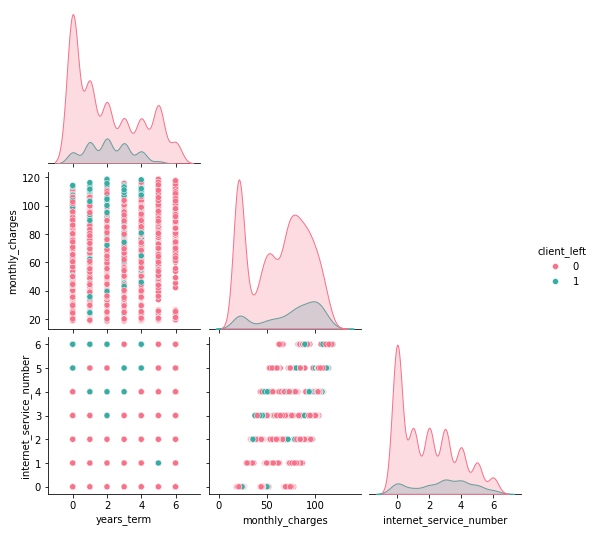

In [120]:
sns.pairplot(
    df,
    vars=['years_term', 'monthly_charges', 'internet_service_number'],
    corner=True,
    hue='client_left',
    palette='husl'
);

Построим графики взаимосвязи скомбинированных признаков и основных числовых - тариф, суммарные расходы и продолжительность контракта в месяцах

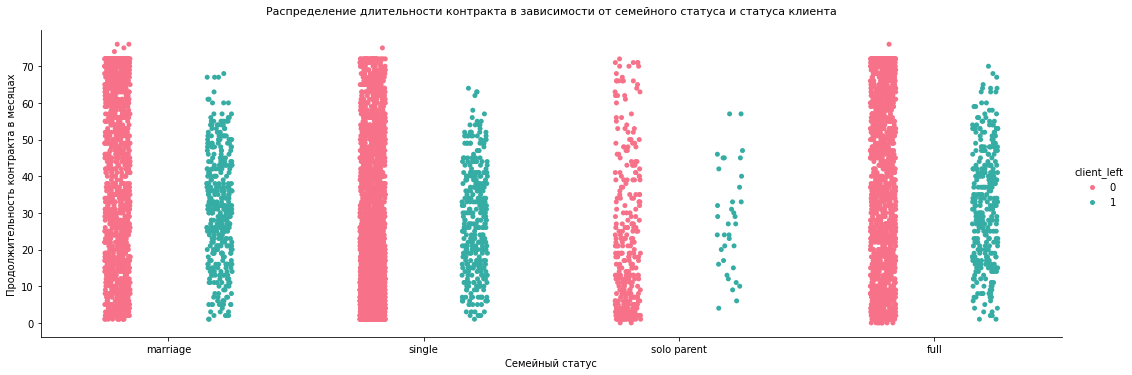

In [121]:
create_catplot(df, col_1='family_status', col_2='months_term', hue='client_left', kind='strip', legend=True, dodge=True,
               aspect=3, title='Распределение длительности контракта в зависимости от семейного статуса и статуса клиента')
plt.xlabel('Семейный статус', size=10)
plt.ylabel('Продолжительность контракта в месяцах', size=10);


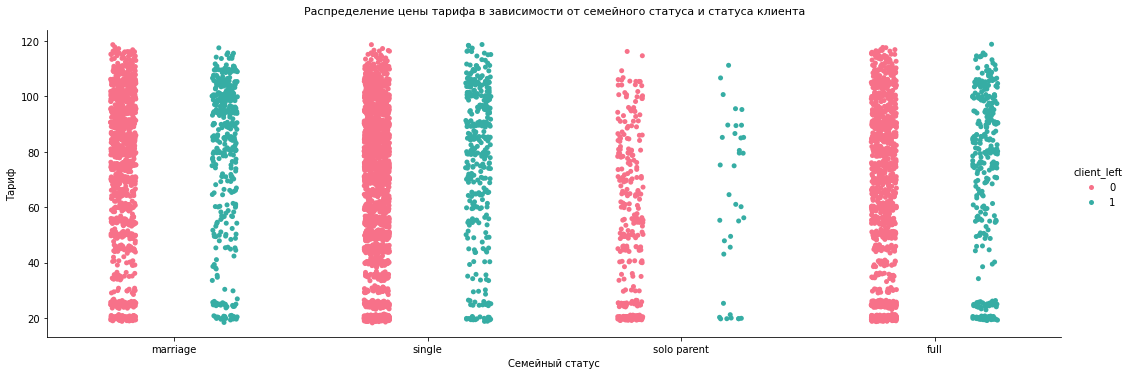

In [122]:
create_catplot(df, col_1='family_status', col_2='monthly_charges', hue='client_left', kind='strip', legend=True, dodge=True,
               aspect=3, title='Распределение цены тарифа в зависимости от семейного статуса и статуса клиента')
plt.xlabel('Семейный статус', size=10)
plt.ylabel('Тариф', size=10);

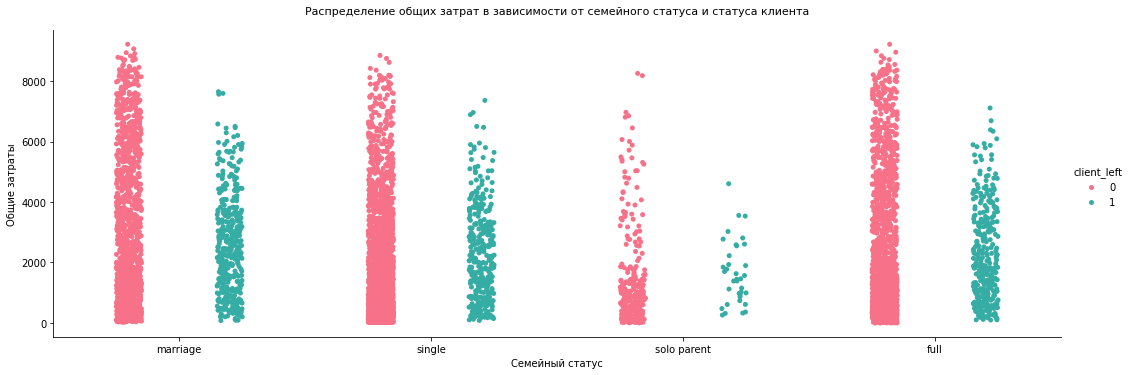

In [123]:
create_catplot(df, col_1='family_status', col_2='total_charges', hue='client_left', kind='strip', legend=True, dodge=True,
               aspect=3, title='Распределение общих затрат в зависимости от семейного статуса и статуса клиента')
plt.xlabel('Семейный статус', size=10)
plt.ylabel('Общие затраты', size=10);

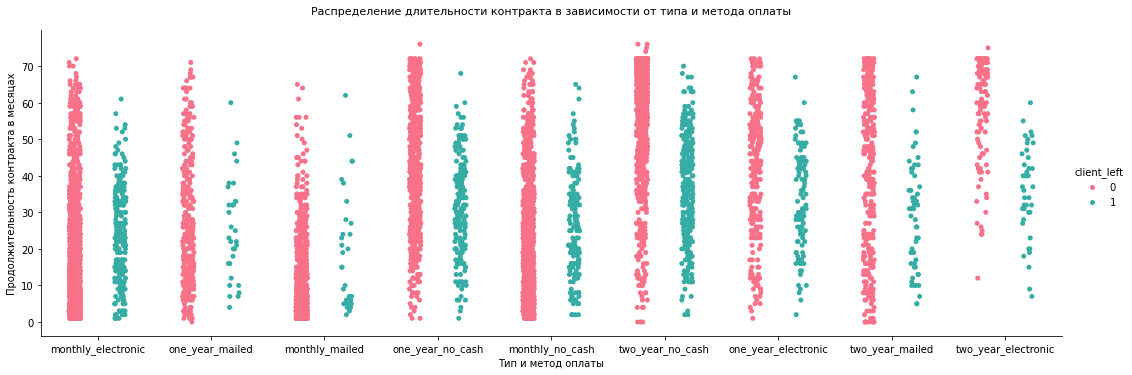

In [124]:
create_catplot(df, col_1='payment_type_comb', col_2='months_term', hue='client_left', kind='strip', legend=True,
               aspect=3, title='Распределение длительности контракта в зависимости от типа и метода оплаты', dodge=True)
plt.xlabel('Тип и метод оплаты', size=10)
plt.ylabel('Продолжительность контракта в месяцах', size=10);

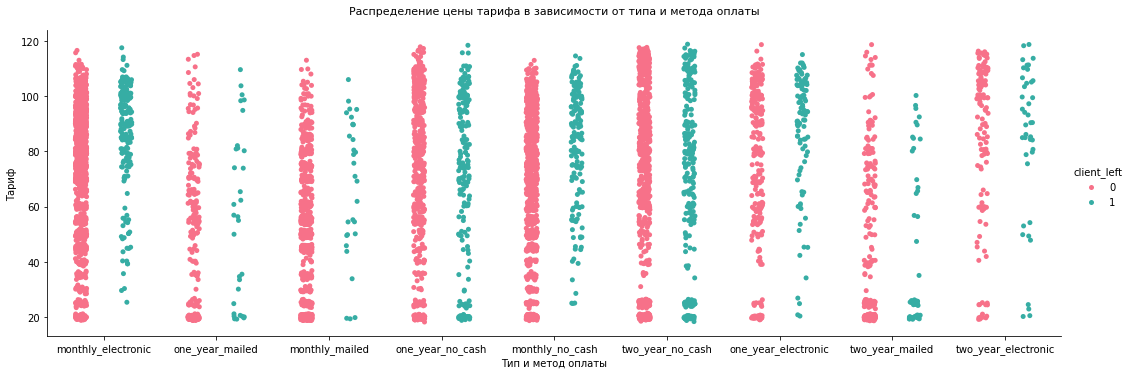

In [125]:
create_catplot(df, col_1='payment_type_comb', col_2='monthly_charges', hue='client_left', kind='strip', legend=True,
               aspect=3, title='Распределение цены тарифа в зависимости от типа и метода оплаты', dodge=True)
plt.xlabel('Тип и метод оплаты', size=10)
plt.ylabel('Тариф', size=10);

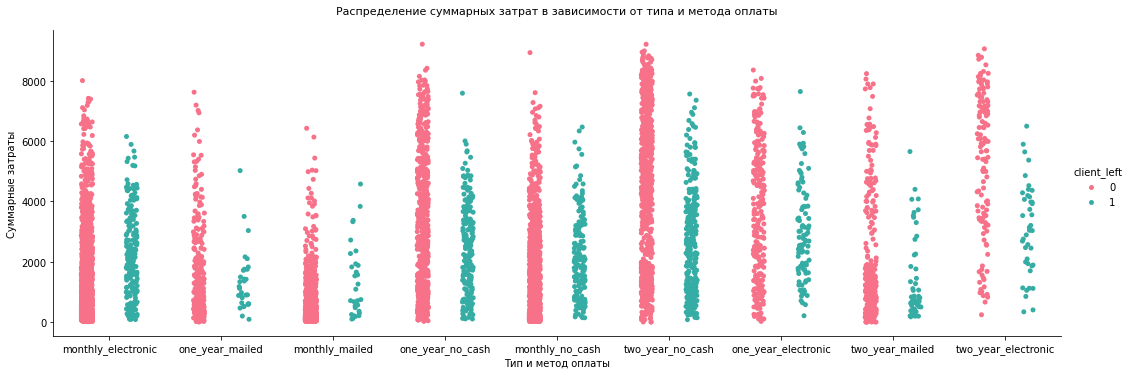

In [126]:
create_catplot(df, col_1='payment_type_comb', col_2='total_charges', hue='client_left', kind='strip', legend=True,
               aspect=3, title='Распределение суммарных затрат в зависимости от типа и метода оплаты', dodge=True)
plt.xlabel('Тип и метод оплаты', size=10)
plt.ylabel('Суммарные затраты', size=10);

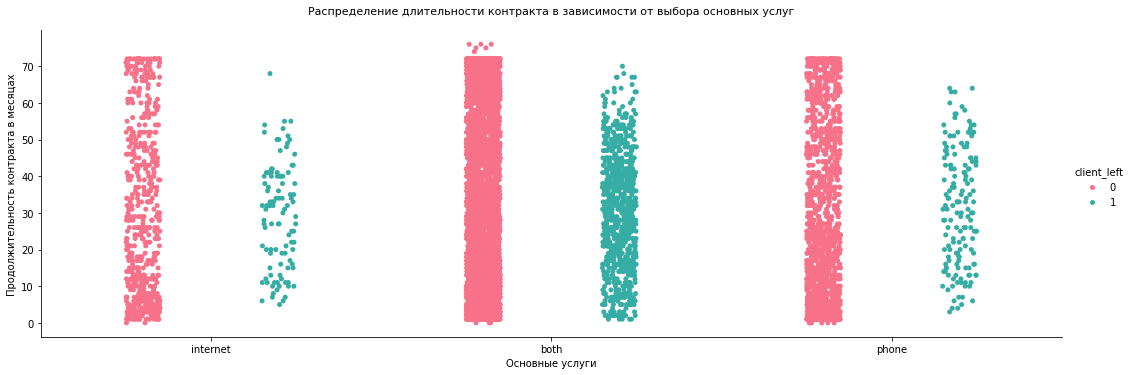

In [127]:
create_catplot(df, col_1 = 'basic_service', col_2 ='months_term', hue='client_left', kind='strip', legend=True,
               aspect=3,  title='Распределение длительности контракта в зависимости от выбора основных услуг', dodge=True)
plt.xlabel('Основные услуги', size=10)
plt.ylabel('Продолжительность контракта в месяцах', size=10);

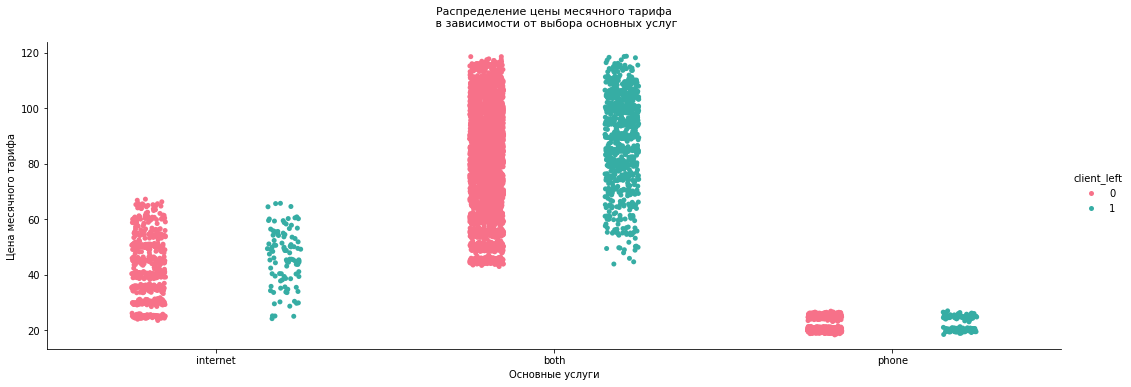

In [128]:
create_catplot(df, col_1 = 'basic_service', col_2 ='monthly_charges', hue='client_left', kind='strip', legend=True, dodge=True,
               aspect=3,  title='Распределение цены месячного тарифа\n в зависимости от выбора основных услуг')
plt.xlabel('Основные услуги', size=10)
plt.ylabel('Цена месячного тарифа', size=10);

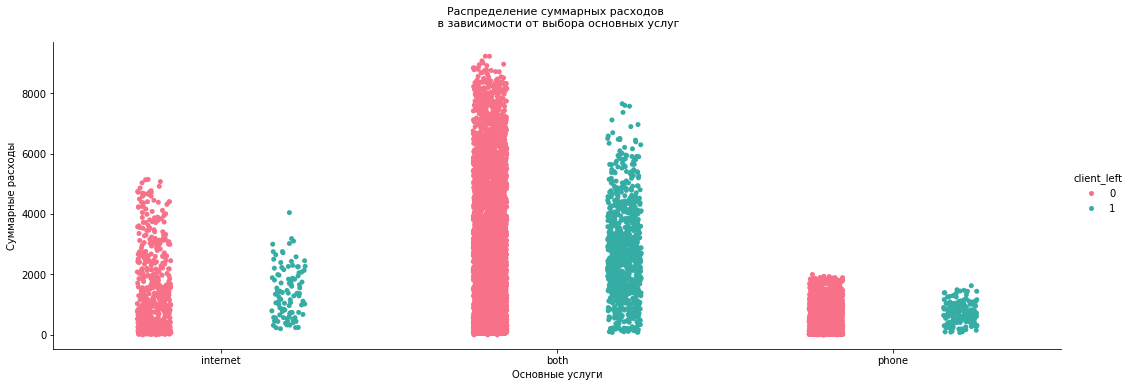

In [129]:
create_catplot(df, col_1 = 'basic_service', col_2 ='total_charges', hue='client_left', kind='strip', legend=True, dodge=True,
               aspect=3,  title='Распределение суммарных расходов \n в зависимости от выбора основных услуг')
plt.xlabel('Основные услуги', size=10)
plt.ylabel('Суммарные расходы', size=10);

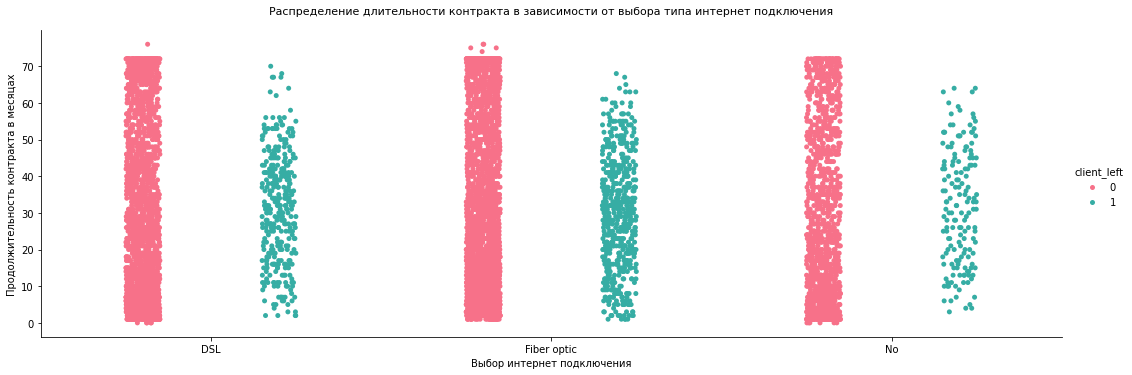

In [130]:
create_catplot(df, col_1 = 'internet_service', col_2 ='months_term', hue='client_left', kind='strip', legend=True,
               aspect=3, dodge=True,  title='Распределение длительности контракта в зависимости от выбора типа интернет подключения')
plt.xlabel('Выбор интернет подключения', size=10)
plt.ylabel('Продолжительность контракта в месяцах', size=10);

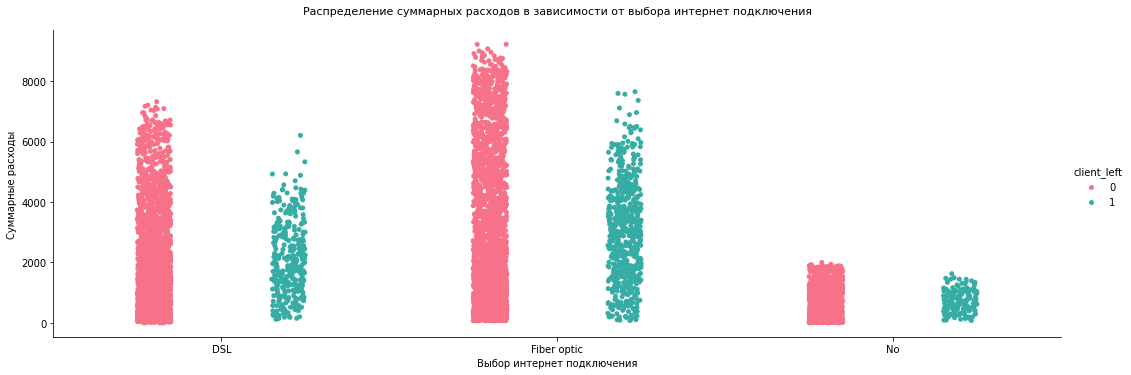

In [131]:
create_catplot(df, col_1 = 'internet_service', col_2 ='total_charges', hue='client_left', kind='strip', legend=True,
               aspect=3, dodge=True, title='Распределение суммарных расходов в зависимости от выбора интернет подключения')
plt.xlabel('Выбор интернет подключения', size=10)
plt.ylabel('Суммарные расходы', size=10);

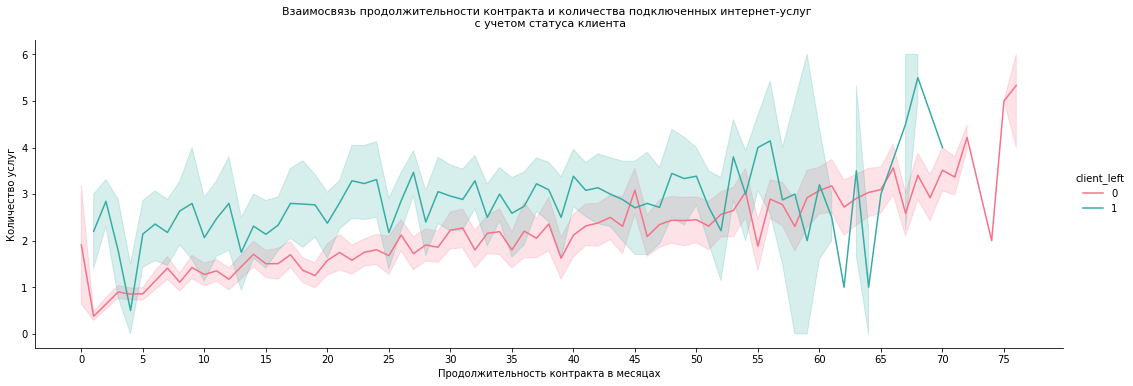

In [132]:
create_relplot(df, col_1 = 'months_term', col_2 = 'internet_service_number',
               hue = 'client_left', palette='husl', title='Взаимосвязь продолжительности контракта и количества подключенных интернет-услуг \n с учетом статуса клиента')
plt.xticks(range(0, contract['months_term'].max() + 1, 5))
plt.ylabel('Количество услуг')
plt.xlabel('Продолжительность контракта в месяцах');

**Распределение активных клиентов и клиентов разорвавших контракт зависит как от основных признаков: суммарные расходы, цена тарифа и продолжительность контракта, <br> так и от дополнительных, вроде статуса семьи и комбинации типа и методов оплаты. Все эти признаки скорее всего пригодятся модели для поиска закономерностей**

#### Генерация новых признаков

Сгенерируем несколько дополнительных признаков в виде статистических показателей основных признаков, сгруппированных по дополнительным(персональным.<br>
Постараемся не дублировать признаки, генерируя сильно коррелирующие.

In [141]:
df['num_person'] = df['family_status'].apply(lambda x: 1 if x =='single' else 2 if (x == 'marriage' or x == 'solo parent') else 3)

In [142]:
df['pay_fam_tot_std'] = (
    df.groupby(['payment_type_comb','family_status'],as_index=False
              )['total_charges'].transform('std')
) 
df['person_serv_term_qt'] = (
    df.groupby(['num_person','basic_service'], as_index=False
              )['months_term'].transform(lambda x: x.quantile(0.75))
)
df['group_term_diff'] = (
    df.groupby(['payment_type_comb', 'family_status'], as_index=False)
    ['months_term'].transform('median')
)
df['group_term_diff'] = df['group_term_diff'] - df['months_term']

df['basic_add_serv_term_std'] = (
    df.groupby(['basic_service', 'multiple_lines', 'internet_service_number'], as_index=False)
    ['months_term'].transform(lambda x: x.quantile(0.75))
)
df['sqr_days'] = df['total_days'] ** 2

In [143]:
df = df.drop('num_person', axis=1)

#### Корреляция между признаками

Высчитаем корреляцию между нашими признаками с помощью библиотеки `phik` так как она может обрабатывать и числовые, и категориальные признаки <br> и улавливать нелинейные зависимости между ними


In [114]:
phik_overview = df.drop('customer_id', axis=1).phik_matrix().round(2)

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'total_charges', 'client_left', 'years_term', 'total_days', 'months_term', 'is_male', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'internet_service_number', 'pay_fam_tot_std', 'person_serv_term_qt', 'group_term_diff', 'basic_add_serv_term_std', 'sqr_days']


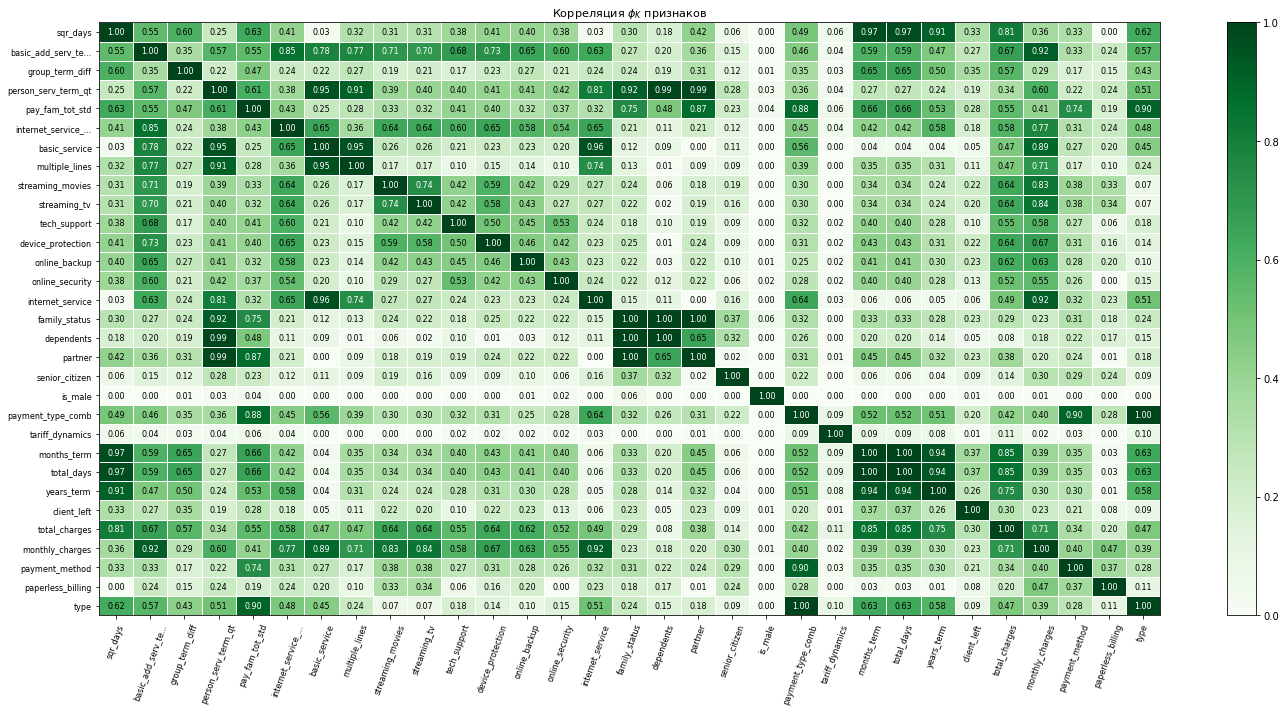

In [115]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Корреляция $\phi_K$ признаков", 
                        fontsize_factor=0.8, figsize=(20, 10))
plt.xticks(rotation = 70)
plt.tight_layout()

- С точки зрения корреляции с целевым признаком пол и динамика тарифа клиента выглядят малополезными.
- Сгенерированные признаки коррелируют друг с другом, однако их корреляция с целевым признаком превосходит большинство исходных признаков, а модели случайного леса и градиентного бустинга, на которые мы нацелились, основаны на ансамбле деревьев решений и устойчивы к мультиколлинеарности, а в CatBoost есть встроенные методы рекурсивного отбора признаков, поэтому новые признаки оставляем.
- Максимальный коэффициент корреляции с целевым признаком у  срока контракта в месяцах - `0.37`.

  
**Однозначно, стоит избавиться от явно дублирующих признаков. Остальные признаки могут принести модели пользу**

Динамика тарифа как категориальный признак не коррелируют с целевым, заменим его числовым в виде разности месячного тарифа и среднемесячных расходов

In [144]:
df.columns

Index(['customer_id', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'client_left', 'years_term',
       'total_days', 'months_term', 'tariff_dynamics', 'payment_type_comb',
       'is_male', 'senior_citizen', 'partner', 'dependents', 'family_status',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'basic_service', 'internet_service_number',
       'pay_fam_tot_std', 'person_serv_term_qt', 'group_term_diff',
       'basic_add_serv_term_std', 'sqr_days'],
      dtype='object')

In [145]:
df['tariff_charges_diff'] = df['total_charges'] / df['months_term']- df['monthly_charges']
df['tariff_charges_diff'] = df['tariff_charges_diff'].fillna(0)

In [146]:
features_to_drop = ['customer_id',  'payment_type_comb', 'family_status', 'years_term']

### Промежуточный вывод

- **На этапе EDA объединенного датафрейма было проведено исследование взаимного распределения признаков и генерация новых характеристик. Визуализация позволила выявить влияние различных параметров на активных клиентов и тех, кто расторг контракт.**
- **Созданы дополнительные признаки, основанные на статистических показателях группированных данных. Анализ корреляции признаков с использованием библиотеки phik выявил, что сгенерированные характеристики взаимосвязаны, но их корреляция с целевым признаком превосходит многие исходные характеристики.**
- **Динамика тарифа показали малую полезность с точки зрения корреляции с целевым показателем и была заменена разницей между ценой тарифа и среднемесячными расходами**

**Созданные признаки могут предоставить ценную информацию для модели**

## Подготовка данных

Зафиксируем константу для параметра `random_state`

In [147]:
RANDOM_SEED = 290124

Отделим целевой признак и разделим датафрейм на обучающую и тестовую выборки в соотношении 3:1

In [148]:
target = 'client_left'

In [149]:
filtered_features = [i for i in df.columns if (i not in target and i not in features_to_drop)]

In [150]:
X = df[filtered_features]
y = df[target]

In [151]:
X_train, X_test, y_train, y_test = (
    train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y)
)

In [152]:
y_train.value_counts()

0    4456
1     826
Name: client_left, dtype: int64

In [153]:
y_test.value_counts()

0    1486
1     275
Name: client_left, dtype: int64

- После разделение выборок на обучающую и тестовую, оставляем тестовую до финального тестирования модели.
- Сравнивать модели будем с помощью стратифицированной кросс-валидации
- Чтобы избежать утечки данных в процессе кросс-валидации, создадим пайплайн предобработки признаков

Определим признаки по категориям

In [154]:
X.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'total_days', 'months_term', 'tariff_dynamics',
       'is_male', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'basic_service', 'internet_service_number',
       'pay_fam_tot_std', 'person_serv_term_qt', 'group_term_diff',
       'basic_add_serv_term_std', 'sqr_days', 'tariff_charges_diff'],
      dtype='object')

Создадим списки численных и категориальных признаков

In [155]:
num_features = ['monthly_charges', 'total_charges', 'pay_fam_tot_std', 'person_serv_term_qt', 'total_days', 
                'months_term', 'group_term_diff', 'basic_add_serv_term_std', 'sqr_days', 'tariff_charges_diff']
cat_features = [i for i in X.columns if i not in num_features]

In [156]:
cat_features

['type',
 'paperless_billing',
 'payment_method',
 'tariff_dynamics',
 'is_male',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'basic_service',
 'internet_service_number']

Объявим методы кодирования для каждой категории

In [157]:
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first')

Создадим метод комбинированного кодирования столбцов

In [158]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ])

Создадим пайплайн с препроцессором и местом для модели

In [159]:
pipe = Pipeline(steps=[
    ('encode', preprocessor),
    ('model', None) #Место для модели
                      ])

## Обучение моделей машинного обучения

**Мы обучим несколько моделей машинного обучения и выберем лучшую среди:**

- `Logistic Regression`
- `KNN`
- `Random Forest`
- `CatBoost`

- Для подбора гиперпараметров и сравнения моделей мы будем использовать стратифицированную кросс-валидацию так как наш целевой признак несбалансирован
- Для подбора гиперпараметров будем использовать фреймворк `optuna`

In [160]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

In [161]:
def get_best_params(study):
    trial_with_highest_auc = max(study.best_trials, key=lambda t: t.values[0])
    best_params = trial_with_highest_auc.params
    
    return best_params

In [162]:
def get_score(study):
    trial_with_highest_auc = max(study.best_trials, key=lambda t: t.values[0])
    auc_score = trial_with_highest_auc.values[0]
    print(f'Лучшее Auc-Roc:{auc_score}')

### Logistic Regression

In [163]:
def objective_logreg(trial):
    #Задаем сетку гиперпараметров
    params = {
        'C': trial.suggest_float('C', 1e-5, 1e5, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'max_iter': trial.suggest_int('max_iter', 50, 1500),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
    }
    #Переадем гиперпараметры в модель
    model = LogisticRegression(**params, class_weight='balanced')

    #Передаем модель в пайплайн
    pipe.steps[1] = ['model', model]
       
    # Оцениваем модель с использованием кросс-валидации
    results = cross_validate(pipe, X_train, y_train, cv=skf, scoring='roc_auc')
    roc_auc = np.mean(results['test_score'])
    return roc_auc

In [164]:
study_lg = optuna.create_study(direction='maximize')
study_lg.optimize(objective_logreg, n_trials=50, show_progress_bar=False)

[I 2024-02-07 14:11:48,073] A new study created in memory with name: no-name-3d705e98-4d97-4687-b6db-50e6310b4fe1
[I 2024-02-07 14:11:49,049] Trial 0 finished with value: 0.744270879817276 and parameters: {'C': 0.00016073105720671197, 'penalty': 'l2', 'max_iter': 64, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.744270879817276.
[I 2024-02-07 14:11:50,249] Trial 1 finished with value: 0.7527496522200493 and parameters: {'C': 0.0004926831873570961, 'penalty': 'l2', 'max_iter': 973, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.7527496522200493.
[I 2024-02-07 14:11:52,052] Trial 2 finished with value: 0.8886107688553944 and parameters: {'C': 7465.819766729424, 'penalty': 'l2', 'max_iter': 283, 'solver': 'liblinear'}. Best is trial 2 with value: 0.8886107688553944.
[I 2024-02-07 14:11:52,684] Trial 3 finished with value: 0.7912018635133936 and parameters: {'C': 0.008567828489348025, 'penalty': 'l2', 'max_iter': 279, 'solver': 'liblinear'}. Best is trial 2 with value: 0.88861076885

In [165]:
lg_best_params = get_best_params(study_lg)

In [166]:
get_score(study_lg)

Лучшее Auc-Roc:0.8909841017992898


### KNN

In [154]:
def objective_knn(trial):
    #Задаем сетку гиперпараметров
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    #Переадем гиперпараметры в модель
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    

    #Передаем модель в пайплайн
    pipe.steps[1] = ('knn', knn_model)
       
    # Оцениваем модель с использованием кросс-валидации
    results = cross_validate(pipe, X_train, y_train, cv=skf, scoring='roc_auc')
    roc_auc = np.mean(results['test_score'])
    return roc_auc

In [155]:
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=15, show_progress_bar=False)

[I 2024-02-06 16:20:54,468] A new study created in memory with name: no-name-aee6c5bf-1b5e-41d4-ade6-d9f5a96b3c74
[I 2024-02-06 16:20:55,392] Trial 0 finished with value: 0.8115720522522487 and parameters: {'n_neighbors': 28, 'weights': 'distance'}. Best is trial 0 with value: 0.8115720522522487.
[I 2024-02-06 16:20:55,908] Trial 1 finished with value: 0.7677061970969777 and parameters: {'n_neighbors': 6, 'weights': 'distance'}. Best is trial 0 with value: 0.8115720522522487.
[I 2024-02-06 16:20:56,430] Trial 2 finished with value: 0.7900191318542564 and parameters: {'n_neighbors': 11, 'weights': 'uniform'}. Best is trial 0 with value: 0.8115720522522487.
[I 2024-02-06 16:20:57,038] Trial 3 finished with value: 0.811193345492081 and parameters: {'n_neighbors': 27, 'weights': 'distance'}. Best is trial 0 with value: 0.8115720522522487.
[I 2024-02-06 16:20:57,784] Trial 4 finished with value: 0.8041434655880194 and parameters: {'n_neighbors': 17, 'weights': 'uniform'}. Best is trial 0 wi

In [156]:
knn_best_params = get_best_params(study_knn)

In [157]:
get_score(study_knn)

Лучшее Auc-Roc:0.8120043786322361


### Random Forest

In [216]:
def objective_rf(trial):
    #Задаем сетку гиперпараметров
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 400),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap' : trial.suggest_categorical('bootstrap', [True, False])
    }
    #Переадем гиперпараметры в модель
    model = RandomForestClassifier(**params, class_weight='balanced', random_state=RANDOM_SEED)

    
    #Передаем модель в пайплайн
    pipe.steps[1] = ['model', model]
       
    # Оцениваем модель с использованием кросс-валидации
    results = cross_validate(pipe, X_train, y_train, cv=skf, scoring='roc_auc')
    roc_auc = np.mean(results['test_score'])
    return roc_auc

In [218]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=10, show_progress_bar=False)

[I 2024-02-06 19:05:48,891] A new study created in memory with name: no-name-c033fbb7-eb42-430d-8a33-7586cc8ccaca
[I 2024-02-06 19:05:54,628] Trial 0 finished with value: 0.8129725351133748 and parameters: {'n_estimators': 244, 'max_depth': 76, 'min_samples_split': 59, 'min_samples_leaf': 337, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8129725351133748.
[I 2024-02-06 19:06:25,067] Trial 1 finished with value: 0.8313939859760225 and parameters: {'n_estimators': 972, 'max_depth': 55, 'min_samples_split': 76, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.8313939859760225.
[I 2024-02-06 19:06:43,695] Trial 2 finished with value: 0.8244224397816069 and parameters: {'n_estimators': 880, 'max_depth': 64, 'min_samples_split': 95, 'min_samples_leaf': 272, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.8313939859760225.
[I 2024-02-06 19:07:01,760] Trial 3 finished with value: 0.8289660

In [219]:
rf_best_params = get_best_params(study_rf)

In [220]:
get_score(study_rf)

Лучшее Auc-Roc:0.8313939859760225


### CATBOOST

In [212]:
def objective_cb(trial):
    params = {
    'iterations':  1000,
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.09),
    'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 50),
    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.8), 
    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['SqrtBalanced', 'Balanced']),
    'depth': trial.suggest_int('depth', 3, 10),
    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
    'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
   # 'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', ['auto_class_weights']),
    "eval_metric": "AUC"
}

    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 20)
        
    elif params['bootstrap_type'] == 'Bernoulli':
       params['subsample'] = trial.suggest_float('subsample', 0.1, 1)

    cbc_model = cbc(**params, random_state=RANDOM_SEED, thread_count=-1, verbose=500, cat_features=cat_features)
    
                 
    # Оцениваем модель с использованием кросс-валидации
    results = cross_validate(cbc_model, X_train, y_train, cv=skf, scoring='roc_auc')
    roc_auc = np.mean(results['test_score'])
    return roc_auc

In [213]:
study_cbc = optuna.create_study(direction='maximize')
study_cbc.optimize(objective_cb, n_trials=15)

[I 2024-02-06 17:47:38,152] A new study created in memory with name: no-name-67d163f8-3b67-40eb-ac17-680f06639441


0:	total: 8.24ms	remaining: 8.24s
500:	total: 4.45s	remaining: 4.43s
999:	total: 8.47s	remaining: 0us
0:	total: 7.65ms	remaining: 7.64s
500:	total: 3.99s	remaining: 3.97s
999:	total: 7.77s	remaining: 0us
0:	total: 6.59ms	remaining: 6.59s
500:	total: 4.01s	remaining: 4s
999:	total: 8.25s	remaining: 0us


[I 2024-02-06 17:48:04,671] Trial 0 finished with value: 0.828912649954589 and parameters: {'learning_rate': 0.04530361912672102, 'l2_leaf_reg': 34, 'colsample_bylevel': 0.05504167893375241, 'auto_class_weights': 'Balanced', 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.828912649954589.


0:	total: 44.7ms	remaining: 44.6s
500:	total: 25.5s	remaining: 25.4s
999:	total: 50.1s	remaining: 0us
0:	total: 52ms	remaining: 52s
500:	total: 23.4s	remaining: 23.3s
999:	total: 47.1s	remaining: 0us
0:	total: 43.7ms	remaining: 43.7s
500:	total: 24s	remaining: 23.9s
999:	total: 48.9s	remaining: 0us


[I 2024-02-06 17:50:33,039] Trial 1 finished with value: 0.8202135888422891 and parameters: {'learning_rate': 0.010931979522063564, 'l2_leaf_reg': 41, 'colsample_bylevel': 0.717507480509782, 'auto_class_weights': 'SqrtBalanced', 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 13.732055806283881}. Best is trial 0 with value: 0.828912649954589.


0:	total: 26.2ms	remaining: 26.2s
500:	total: 9.07s	remaining: 9.03s
999:	total: 20.8s	remaining: 0us
0:	total: 26.6ms	remaining: 26.6s
500:	total: 9.52s	remaining: 9.48s
999:	total: 21.4s	remaining: 0us
0:	total: 23.1ms	remaining: 23s
500:	total: 9.44s	remaining: 9.4s
999:	total: 21.2s	remaining: 0us


[I 2024-02-06 17:51:38,293] Trial 2 finished with value: 0.8389191277260323 and parameters: {'learning_rate': 0.0217919427179218, 'l2_leaf_reg': 40, 'colsample_bylevel': 0.22603087926417056, 'auto_class_weights': 'Balanced', 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.2848579702083285}. Best is trial 2 with value: 0.8389191277260323.


0:	total: 20.7ms	remaining: 20.7s
500:	total: 9.13s	remaining: 9.09s
999:	total: 19.2s	remaining: 0us
0:	total: 18.2ms	remaining: 18.1s
500:	total: 9.37s	remaining: 9.33s
999:	total: 19.9s	remaining: 0us
0:	total: 22.2ms	remaining: 22.2s
500:	total: 9.05s	remaining: 9.02s
999:	total: 19.2s	remaining: 0us


[I 2024-02-06 17:52:38,434] Trial 3 finished with value: 0.834164115107484 and parameters: {'learning_rate': 0.034826608249550736, 'l2_leaf_reg': 18, 'colsample_bylevel': 0.6065244318348496, 'auto_class_weights': 'SqrtBalanced', 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.16311737268574028}. Best is trial 2 with value: 0.8389191277260323.


0:	total: 25ms	remaining: 25s
500:	total: 1m 10s	remaining: 1m 10s
999:	total: 2m 53s	remaining: 0us
0:	total: 19.8ms	remaining: 19.7s
500:	total: 1m 13s	remaining: 1m 13s
999:	total: 2m 50s	remaining: 0us
0:	total: 28.1ms	remaining: 28s
500:	total: 1m 10s	remaining: 1m 9s
999:	total: 2m 54s	remaining: 0us


[I 2024-02-06 18:01:19,359] Trial 4 finished with value: 0.8682424183077163 and parameters: {'learning_rate': 0.06556049796496187, 'l2_leaf_reg': 3, 'colsample_bylevel': 0.758857266781269, 'auto_class_weights': 'SqrtBalanced', 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 0.8682424183077163.


0:	total: 12.6ms	remaining: 12.6s
500:	total: 4.89s	remaining: 4.87s
999:	total: 9.83s	remaining: 0us
0:	total: 8.8ms	remaining: 8.79s
500:	total: 4.82s	remaining: 4.8s
999:	total: 9.71s	remaining: 0us
0:	total: 8.98ms	remaining: 8.98s
500:	total: 4.81s	remaining: 4.79s
999:	total: 10.2s	remaining: 0us


[I 2024-02-06 18:01:50,840] Trial 5 finished with value: 0.8423585934739982 and parameters: {'learning_rate': 0.033386670567715056, 'l2_leaf_reg': 41, 'colsample_bylevel': 0.7424822505831495, 'auto_class_weights': 'SqrtBalanced', 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 0.8682424183077163.


0:	total: 9.98ms	remaining: 9.97s
500:	total: 4.36s	remaining: 4.34s
999:	total: 8.38s	remaining: 0us
0:	total: 7.66ms	remaining: 7.65s
500:	total: 3.96s	remaining: 3.95s
999:	total: 7.89s	remaining: 0us
0:	total: 9.42ms	remaining: 9.41s
500:	total: 4.34s	remaining: 4.33s
999:	total: 8.71s	remaining: 0us


[I 2024-02-06 18:02:17,523] Trial 6 finished with value: 0.8318157865804382 and parameters: {'learning_rate': 0.020201824000985056, 'l2_leaf_reg': 19, 'colsample_bylevel': 0.6777282273054672, 'auto_class_weights': 'SqrtBalanced', 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 11.390315386953498}. Best is trial 4 with value: 0.8682424183077163.


0:	total: 12.7ms	remaining: 12.7s
500:	total: 3.96s	remaining: 3.94s
999:	total: 7.62s	remaining: 0us
0:	total: 8.64ms	remaining: 8.63s
500:	total: 3.7s	remaining: 3.69s
999:	total: 7.4s	remaining: 0us
0:	total: 8.27ms	remaining: 8.27s
500:	total: 4.08s	remaining: 4.07s
999:	total: 7.89s	remaining: 0us


[I 2024-02-06 18:02:42,148] Trial 7 finished with value: 0.8374589464762728 and parameters: {'learning_rate': 0.049773678912880356, 'l2_leaf_reg': 23, 'colsample_bylevel': 0.45645341691040886, 'auto_class_weights': 'Balanced', 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.616234364607941}. Best is trial 4 with value: 0.8682424183077163.


0:	total: 11.5ms	remaining: 11.5s
500:	total: 4.34s	remaining: 4.32s
999:	total: 8.73s	remaining: 0us
0:	total: 8.64ms	remaining: 8.63s
500:	total: 4.4s	remaining: 4.39s
999:	total: 8.79s	remaining: 0us
0:	total: 7.42ms	remaining: 7.41s
500:	total: 4.32s	remaining: 4.31s
999:	total: 8.74s	remaining: 0us


[I 2024-02-06 18:03:10,199] Trial 8 finished with value: 0.8172944731011027 and parameters: {'learning_rate': 0.03986219044673013, 'l2_leaf_reg': 30, 'colsample_bylevel': 0.16223572537224387, 'auto_class_weights': 'SqrtBalanced', 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 15.649259888873706}. Best is trial 4 with value: 0.8682424183077163.


0:	total: 78.2ms	remaining: 1m 18s
500:	total: 13.2s	remaining: 13.1s
999:	total: 55.9s	remaining: 0us
0:	total: 64.1ms	remaining: 1m 4s
500:	total: 12.3s	remaining: 12.2s
999:	total: 55s	remaining: 0us
0:	total: 73.1ms	remaining: 1m 12s
500:	total: 14.8s	remaining: 14.7s
999:	total: 57.7s	remaining: 0us


[I 2024-02-06 18:06:00,744] Trial 9 finished with value: 0.848346911803616 and parameters: {'learning_rate': 0.020773471566561615, 'l2_leaf_reg': 27, 'colsample_bylevel': 0.2381711171229452, 'auto_class_weights': 'Balanced', 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 4 with value: 0.8682424183077163.


0:	total: 17.3ms	remaining: 17.3s
500:	total: 1m 43s	remaining: 1m 42s
999:	total: 3m 59s	remaining: 0us
0:	total: 120ms	remaining: 1m 59s
500:	total: 1m 44s	remaining: 1m 43s
999:	total: 4m 51s	remaining: 0us
0:	total: 302ms	remaining: 5m 1s
500:	total: 1m 55s	remaining: 1m 55s
999:	total: 4m 26s	remaining: 0us


[I 2024-02-06 18:19:20,994] Trial 10 finished with value: 0.8803288262092988 and parameters: {'learning_rate': 0.07488022584019019, 'l2_leaf_reg': 3, 'colsample_bylevel': 0.47594277141747104, 'auto_class_weights': 'SqrtBalanced', 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.985456203258373}. Best is trial 10 with value: 0.8803288262092988.


0:	total: 37.3ms	remaining: 37.2s
500:	total: 1m 55s	remaining: 1m 54s
999:	total: 4m 29s	remaining: 0us
0:	total: 38.4ms	remaining: 38.4s
500:	total: 2m 31s	remaining: 2m 30s
999:	total: 5m 51s	remaining: 0us
0:	total: 300ms	remaining: 5m
500:	total: 1m 54s	remaining: 1m 54s
999:	total: 4m 13s	remaining: 0us


[I 2024-02-06 18:33:58,250] Trial 11 finished with value: 0.8850372734621058 and parameters: {'learning_rate': 0.07749419140079976, 'l2_leaf_reg': 3, 'colsample_bylevel': 0.4909968077468341, 'auto_class_weights': 'SqrtBalanced', 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9889275107455449}. Best is trial 11 with value: 0.8850372734621058.


0:	total: 246ms	remaining: 4m 5s
500:	total: 1m 44s	remaining: 1m 44s
999:	total: 3m 59s	remaining: 0us
0:	total: 236ms	remaining: 3m 55s
500:	total: 1m 44s	remaining: 1m 44s
999:	total: 4m 1s	remaining: 0us
0:	total: 13.9ms	remaining: 13.9s
500:	total: 1m 44s	remaining: 1m 43s
999:	total: 3m 58s	remaining: 0us


[I 2024-02-06 18:46:01,233] Trial 12 finished with value: 0.8761570232748834 and parameters: {'learning_rate': 0.08591121668282009, 'l2_leaf_reg': 5, 'colsample_bylevel': 0.4598659346876855, 'auto_class_weights': 'SqrtBalanced', 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9898313955363283}. Best is trial 11 with value: 0.8850372734621058.


0:	total: 24.8ms	remaining: 24.8s
500:	total: 1m 48s	remaining: 1m 47s
999:	total: 4m 14s	remaining: 0us
0:	total: 125ms	remaining: 2m 5s
500:	total: 1m 48s	remaining: 1m 48s
999:	total: 4m 19s	remaining: 0us
0:	total: 23.7ms	remaining: 23.7s
500:	total: 1m 49s	remaining: 1m 49s
999:	total: 4m 19s	remaining: 0us


[I 2024-02-06 18:58:57,763] Trial 13 finished with value: 0.8692551321893784 and parameters: {'learning_rate': 0.07290543966710585, 'l2_leaf_reg': 11, 'colsample_bylevel': 0.540255333812106, 'auto_class_weights': 'SqrtBalanced', 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9952487639010345}. Best is trial 11 with value: 0.8850372734621058.


0:	total: 58.9ms	remaining: 58.8s
500:	total: 23.8s	remaining: 23.7s
999:	total: 53.6s	remaining: 0us
0:	total: 57.6ms	remaining: 57.5s
500:	total: 24s	remaining: 23.9s
999:	total: 54.1s	remaining: 0us
0:	total: 19.1ms	remaining: 19.1s
500:	total: 24.6s	remaining: 24.5s
999:	total: 54.2s	remaining: 0us


[I 2024-02-06 19:01:41,842] Trial 14 finished with value: 0.8590118213429955 and parameters: {'learning_rate': 0.06549653398621999, 'l2_leaf_reg': 11, 'colsample_bylevel': 0.3536780221948129, 'auto_class_weights': 'SqrtBalanced', 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7093490615294722}. Best is trial 11 with value: 0.8850372734621058.


In [214]:
cb_best_params = get_best_params(study_cbc)

In [215]:
get_score(study_cbc)

Лучшее Auc-Roc:0.8850372734621058


### Промежуточный вывод

- Линейная модель с результатом 0.89 обошла все модели, но есть риск того что она переобучилась
- Модель `KNN` показала худший результат
- Случайный лес слегка опередил с результатом `Auc-Roc`- 0.83
- Catboost показал схожую эффективность с линейной

### Оценка признаков и разбор ошибок модели

Обычные методы получения рейтинга важности признаков не очень надежны, так как вклад сильно скореллированных признаков может делиться между ними и истинно важные признаки могут оказаться внизу рейтинга.<br>
Мы же воспользуемся библиотекой SHAP. С помощью нее происходит оценка предсказаний модели с  и без конкретного признака и на основе этого опредлеляется его вклад

In [225]:
train_index, val_index = [], []
SHAP_values_per_fold = []

In [226]:
for fold in skf.split(X_train, y_train):
    train_index.append(fold[0]), val_index.append(fold[1])

In [227]:
for i, (fold_train_index, fold_val_index) in enumerate(zip(train_index, val_index)): #-#-#


    X_train_fold, X_val_fold = X_train.iloc[fold_train_index, :], X_train.iloc[fold_val_index, :]
    y_train_fold, y_val_fold = y_train.iloc[fold_train_index], y_train.iloc[fold_val_index]

    model = cbc(**cb_best_params, silent=True, thread_count=-1, random_state=RANDOM_SEED, cat_features=cat_features)
    model.fit(X_train_fold, y_train_fold)
    
    explainer = shap.TreeExplainer(model)
    val_dataset = Pool(data=X_val_fold, label=y_val_fold, cat_features=cat_features)
    shap_values = explainer.shap_values(val_dataset)
    for SHAPs in shap_values:
        SHAP_values_per_fold.append(SHAPs) #-#-#

In [228]:
new_index = [ix for ix_test_fold in val_index for ix in ix_test_fold]

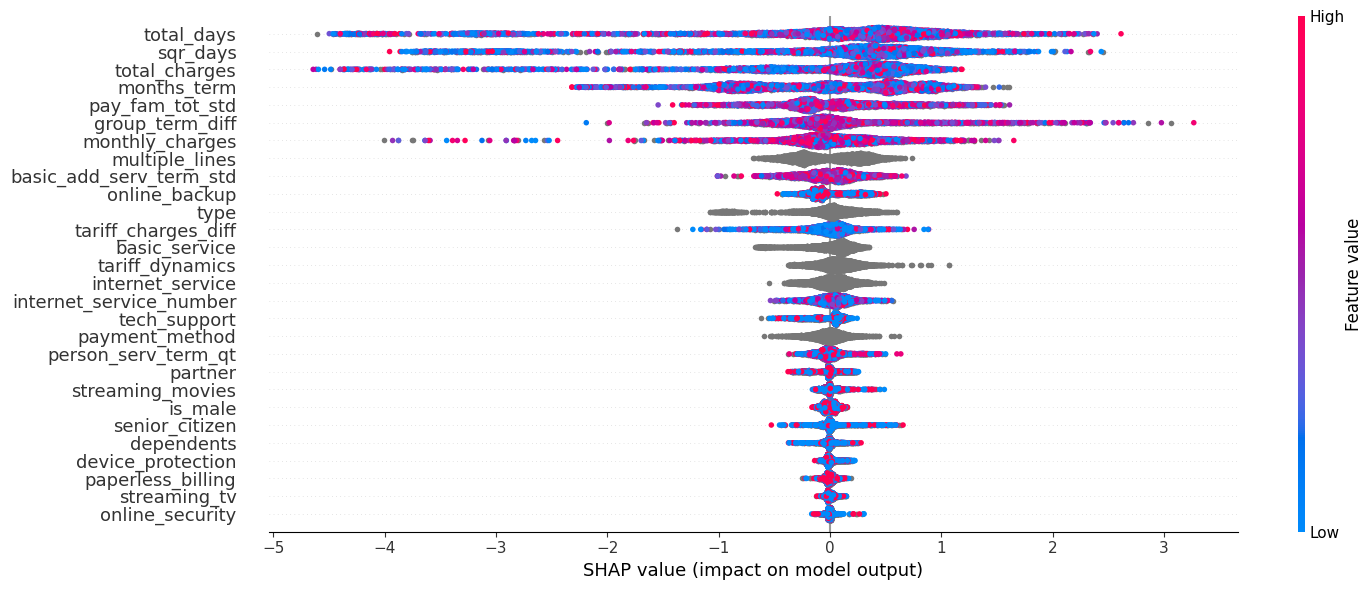

In [229]:
shap.summary_plot(np.array(SHAP_values_per_fold), X_train.reindex(new_index), max_display = 35, plot_size = (15, 6))

Наибольшее влияение по результатам работы модели, оказывают:
- Срок контракта
- Суммарные расходы
- Цена тарифа
- Подключение таких доп. услуг как мультилиния и резервное копирование
  
Так же высокое значение оказали сгенерированные нами агрегированные статистики

### Объеденим модели

Объеденим две модели, в качестве финальной выберем линейную регрессию. Протестируем стек с помощью кросс-валидации

In [236]:
models = [
    ('LG', make_pipeline(preprocessor, LogisticRegression(**lg_best_params, class_weight='balanced'))),
    #('RF', make_pipeline(preprocessor,  RandomForestClassifier(**rf_best_params, class_weight='balanced', random_state=RANDOM_SEED))),
    ('CB', cbc(**cb_best_params, random_state=RANDOM_SEED, thread_count=-1, cat_features=cat_features, silent=True))
]

In [237]:
stc = StackingClassifier(estimators=models, final_estimator=LogisticRegression(class_weight='balanced'))

In [238]:
results = cross_val_score(stc, X_train, y_train, cv=skf, scoring='roc_auc')

In [248]:
print(f'Auc-Roc стека моделей на кросс-валидации: {np.mean(results)}')

Auc-Roc стека моделей на кросс-валидации: 0.9053476409587004


Стек наших моделей показал прирост по сравнению с каждой по-отдельности!

## Финальное тестирование

Обучим ансамбль наших моделей на обучающей выборке и протестируем на тестовой

In [239]:
stc.fit(X_train, y_train)

StackingClassifier(estimators=[('LG',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('cat',
                                                                                  OneHotEncoder(drop='first'),
                                                                                  ['type',
                                                                                   'paperless_billing',
                                                                                   'payment_method',
                                                                                   'tariff_dynamics',
                                                                                   'is_male',
                                                                                   'senior_citizen',
                                                                                   'partner',
                                                                                   'dependents',
                                                                                   'internet_service',
                                                                                   'online_security',
                                                                                   'online_backup',
                                                                                   'device_protection',
                                                                                   'tech_support',
                                                                                   'streami...
                                                                                   'person_serv_term_qt',
                                                                                   'total_days',
                                                                                   'months_term',
                                                                                   'group_term_diff',
                                                                                   'basic_add_serv_term_std',
                                                                                   'sqr_days',
                                                                                   'tariff_charges_diff'])])),
                                                ('logisticregression',
                                                 LogisticRegression(C=98820.29945066477,
                                                                    class_weight='balanced',
                                                                    max_iter=962))])),
                               ('CB',
                                <catboost.core.CatBoostClassifier object at 0x7f59d0b50250>)],
                   final_estimator=LogisticRegression(class_weight='balanced'))

In [240]:
y_pred = stc.predict_proba(X_test)[:, 1]

In [241]:
y_pred_binary = (y_pred > 0.5).astype(int)

In [242]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [243]:
print('ROC-AUC score', roc_auc_score(y_test, y_pred))
print('Accuracy score', accuracy_score(y_test, y_pred_binary))

ROC-AUC score 0.9062938945307721
Accuracy score 0.8313458262350937


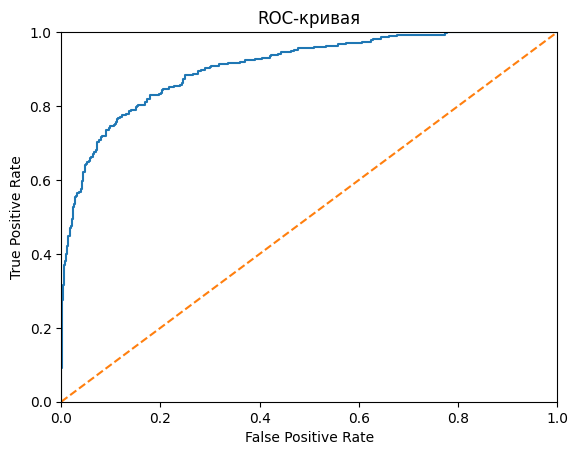

In [244]:
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
plt.title('ROC-кривая')
plt.show()

In [245]:
print(classification_report(y_true = y_test,
                            y_pred = y_pred_binary))

              precision    recall  f1-score   support

           0       0.96      0.84      0.89      1486
           1       0.48      0.80      0.60       275

    accuracy                           0.83      1761
   macro avg       0.72      0.82      0.75      1761
weighted avg       0.88      0.83      0.85      1761



## Финальный вывод


**Проект был посвящен разработке модели для прогнозирования ухода клиентов телекоммуникационной компании. В ходе работы был проведен обширный анализ данных, выполнена предобработка и создание новых признаков, а также выбор и обучение моделей.**

1. **Анализ данных и EDA:<br>
Была произведена предобработка датафреймов, скорректированы типы данных, выведен целевой признак, сгенерированы новые признаки и отброшены опасные с точки зрения утечки данных.<br>
Был проведен анализ данных, визуализировано и изучено взаимное распределение признаков с учетом целевого признака. Были выявлены следующие тенденции**
    - Возникшая в последние 2 года положительная динамика уменьшения отношения разорванных контрактов к заключенным
    - Ушедшие клиенты имеют в среднем более дорогой тариф чем активные.
    - В основном клиенты уходят после 2-4 лет. Новые клиенты и те, кто с компанией более 5 лет, почти не склонны к разрыву.
    - Процент разорванных контрактов сильно различается в зависимости от типа и метода оплаты, семейного статуса клиента, количества подключенных доп. услуг.

2. **Подготовка данных и обучение моделей:<br>
Выполнена подготовка данных, включая разделение на обучающую и тестовую выборки, создание пайплайна предобработки признаков.<br> Проведен подбор гиперпараметров с использованием стратифицированной кросс-валидации.<br> Были использованы следующие модели:**

    - Logistic Regression
    - KNN
    - Random Forest
    - CatBoost. 

3. **Результаты и выводы:** <br>
В качестве финальной модели для обеспечения большей устойчивости к новым данным был выбран ансамбль из моделей CatBoost, Random Forest и финальной мета-модели - Logistic Regression
ROC-AUC score для финальной модели составил 0.906, а accuracy score - 0.83. Модель проявила высокую полноту в предсказании клиентов, не собирающихся уходить - 0.97. И также продемонстрировала неплохую способность предсказывать уход клиентов, что подтверждают значения precision, recall и f1-score для класса "1". Использование такой модели не повлечет за собой чрезмерное число ложных предложений купонов - доля тех кому нужно предложить купон от всех предложений - 0.84, а из тех клиентов, что разорвали контракт модель верно определила почти половину
4. **Рекомендации заказчику:** <br>

    - Общее впечатление заключается в том, что базовые услуги предоставляются компанией по приемлемой цене относительно конкурентов и удовлетворяют клиентов. Однако, по мере увеличения числа оплачиваемых услуг и повышения тарифов, клиенты начинают проявлять интерес к более выгодным предложениям, что может подталкивать их к переходу к другим операторам.

    - Рекомендуется проанализировать комплексные предложений и особых условий для клиентов, которые используют несколько услуг. Это особенно важно, учитывая негативную динамику среди клиентов с более дорогими тарифами и потенциальные потери от ухода таких клиентов.

    - Дополнительно рекомендуется провести анализ долгосрочных тарифов, поскольку они, кажется, ассоциируются с меньшей клиентской лояльностью, нежели ежемесячные.
    
    - Наконец, рекомендуется рассмотрение внедрения семейных предложений, поскольку клиенты, состоящие в браке, более склонны к разрыву контракта.